# Converge Spin Baths

In [2]:
# %load_ext autoreload
# %autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('NVcenter-default')

import numpy as np 
import matplotlib.pyplot as plt
import qutip as q
import time
import random
import seaborn as sns

### 1. Create spins baths (12 x 6 = 72)

In [188]:
for density_key in ['low_density', 'intermediate_density', 'high_density', 'very_high_density]:
    for depth in [5e-9, 10e-9, 15e-9]:

        density_dict = {'low_density': 1e-3/1e-18, 'intermediate_density': 5e-3/1e-18, 'high_density': 20e-3/1e-18, 'very_high_density': 50e-3/1e-18}
        density = density_dict[density_key]
        rmax = np.sqrt(7 / (density * np.pi))
        
        num_baths, num_init_states, all_init_states = 5000, 1, False
        directory = os.path.join(os.getcwd(), "baths", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
        filename = f"7_spins"
        kwargs = dict(
            density = density,
            shape = 'circle',
            rmin = 0, 
            rmax = rmax,
            depth = depth,
            bath_kwargs = dict(Bz=500e-4, depth=depth),
        )
        
        spin_bath = SpinBath('e', **kwargs)
        bath_configs, metadata = spin_bath.calc_spin_baths(num_baths, num_init_states, all_init_states=all_init_states)
        save_spin_baths(bath_configs, metadata, directory, filename)
        print("Saved as", os.path.join(directory, filename + '.json'))
        
        # bath_polarization = calc_bath_polarization(bath_configs)
        # print("Number of bath spins: ", spin_bath.num_spins)
        # print("Bath Polarization: ", bath_polarization)
        
        # directory = os.path.join(os.getcwd(), "baths", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
        # filename = os.path.join( "7_spins")
        # bath_configs, metadata = load_spin_baths(filename, directory, load_metadata=True)
        
        for num_spins in [2,3,4,5,6]:
            rmin, rmax_cutoff = 0, np.sqrt(num_spins / (density * np.pi))
            metadata['rmax'] = rmax_cutoff
            cutoff = np.sqrt( (depth)**2 + (rmax_cutoff)**2)
            bath_configs_filtered = cut_spin_bath(bath_configs, cutoff)
            
            filename_cutoff = os.path.join( f"{num_spins}_spins")
            save_spin_baths(bath_configs_filtered, metadata, directory, filename_cutoff)
            print("Saved as", os.path.join(directory, filename_cutoff + '.json'))

Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\baths\.important\converge\high_density_5nm_depth\7_spins.json
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\baths\.important\converge\high_density_5nm_depth\2_spins.json
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\baths\.important\converge\high_density_5nm_depth\3_spins.json
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\baths\.important\converge\high_density_5nm_depth\4_spins.json
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\baths\.important\converge\high_density_5nm_depth\5_spins.json
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\baths\.important\converge\high_density_5nm_depth\6_spins.json
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\baths\.important\converge\high_density_10nm_depth\7_spins.json
Saved as C:\Users\Dennis H

### 2. Calculate density matrix trajectories (50 batches per bath) 

In [78]:
t0 = time.time()

env_approx_level = 'full_bath'
Bz = 0

for density_key in ['high_density']: # ['low_density', 'intermediate_density', 'high_density', 'very_high_density]:
    for depth in [5e-9, 10e-9, 15e-9]:

        directory = os.path.join(os.getcwd(), "baths", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
        for batch_idx in np.arange(1, 51):
            for num_spins in [2,3,4,5,6,7]:
                filename = f'{num_spins}_spins'
                bath_configs = load_spin_baths(filename, directory)
                
                # create an instance of the Environment2 class
                register_config = [('NV', (0, 0, 0), 0, dict(D_gs=0, Bz=Bz, N_zz=0, can_flip=False))]
                bath_configs_batch = bath_configs[(batch_idx-1)*100:batch_idx*100]
                kwargs = dict(dm_offset=1e-5, verbose=False, env_approx_level=env_approx_level, bath_configs=bath_configs_batch, suter_method=False, thermal_bath=True, parallelization=True)
                env = Environment2(register_config, **kwargs)
            
                # calculate the populations
                t_end, t_steps = 100e-6, 500
                env.gate_props_list = [("free_evo", dict(t=t_end))]
                t_list = np.linspace(0, t_end, t_steps)
                HGate = 1j * env.calc_U_rot(np.pi, 0, theta=np.pi / 4)
                HGate_phase = 1j * env.calc_U_rot(np.pi, 0, theta=np.pi / 4) # np.pi/2
                old_register_states = [HGate * q.fock_dm(2,0) * HGate]
                states = env.calc_states(t_list=t_list, old_register_states=old_register_states)[0]
                states = np.array([(HGate_phase * state * HGate_phase).full() for state in states])
                
                # saving
                save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
                save_filename = f'{num_spins}_spins_batch_{batch_idx}'
                os.makedirs(save_directory, exist_ok=True)
                save_loc = os.path.join(save_directory, save_filename)
                np.save(save_loc, states)
                print(f'Saved as {save_loc}.npy')
                print("Time: ", time.time()-t0)

# 2500 batches of size 100 = 250_000 systems with up to 7 bath spins
# 1258 with 1000 batch size (20 minutes)
# 2000 with 100 batch size (30 minutes)
# whole run 143354

Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_1.npy
Time:  5.153472900390625


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_1.npy
Time:  12.137988090515137


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_1.npy
Time:  31.74672794342041


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.74it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_1.npy
Time:  68.55874919891357


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_1.npy
Time:  165.49203872680664


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.67s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_1.npy
Time:  333.2549695968628


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_2.npy
Time:  338.91347312927246


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_2.npy
Time:  352.41355872154236


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_2.npy
Time:  368.7958791255951


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_2.npy
Time:  396.4522249698639


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_2.npy
Time:  504.9181389808655


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.67s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_2.npy
Time:  672.1353054046631


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_3.npy
Time:  677.9497799873352


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_3.npy
Time:  685.678108215332


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_3.npy
Time:  700.886323928833


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_3.npy
Time:  741.2367215156555


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_3.npy
Time:  834.1199271678925


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_3.npy
Time:  989.7906520366669


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_4.npy
Time:  995.2599365711212


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_4.npy
Time:  1002.7419593334198


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_4.npy
Time:  1013.8078150749207


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_4.npy
Time:  1044.9092223644257


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_4.npy
Time:  1137.4006488323212


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_4.npy
Time:  1291.3431680202484


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_5.npy
Time:  1296.7957770824432


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_5.npy
Time:  1303.752195596695


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_5.npy
Time:  1311.7769651412964


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_5.npy
Time:  1334.7430419921875


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_5.npy
Time:  1410.5676362514496


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_5.npy
Time:  1571.0218405723572


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_6.npy
Time:  1576.5299625396729


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_6.npy
Time:  1590.0747594833374


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_6.npy
Time:  1607.9676229953766


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_6.npy
Time:  1648.5524249076843


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_6.npy
Time:  1759.7641263008118


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_6.npy
Time:  1914.8962035179138


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_7.npy
Time:  1921.351093530655


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_7.npy
Time:  1934.619622707367


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_7.npy
Time:  1952.6060047149658


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_7.npy
Time:  1995.6673593521118


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_7.npy
Time:  2092.576848745346


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_7.npy
Time:  2248.225156068802


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_8.npy
Time:  2253.6528284549713


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_8.npy
Time:  2260.765090942383


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_8.npy
Time:  2276.324303150177


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_8.npy
Time:  2302.329628944397


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_8.npy
Time:  2373.349466562271


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_8.npy
Time:  2537.627465724945


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_9.npy
Time:  2543.2952888011932


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_9.npy
Time:  2550.7395577430725


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_9.npy
Time:  2567.1726903915405


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_9.npy
Time:  2594.7401599884033


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_9.npy
Time:  2687.345449924469


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_9.npy
Time:  2839.71945810318


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_10.npy
Time:  2846.1112957000732


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_10.npy
Time:  2853.3349270820618


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_10.npy
Time:  2870.271989107132


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_10.npy
Time:  2898.2836639881134


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_10.npy
Time:  2987.0254848003387


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_10.npy
Time:  3142.103526353836


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_11.npy
Time:  3147.4981112480164


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_11.npy
Time:  3155.1109437942505


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_11.npy
Time:  3171.8401651382446


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_11.npy
Time:  3206.7617902755737


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_11.npy
Time:  3290.4013476371765


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.66s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_11.npy
Time:  3457.3657081127167


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_12.npy
Time:  3463.1873891353607


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_12.npy
Time:  3476.91500043869


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_12.npy
Time:  3493.3479902744293


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_12.npy
Time:  3525.2397196292877


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_12.npy
Time:  3611.486705303192


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_12.npy
Time:  3766.5121536254883


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_13.npy
Time:  3772.775846719742


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_13.npy
Time:  3786.2814557552338


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_13.npy
Time:  3802.4061880111694


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_13.npy
Time:  3830.341944217682


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_13.npy
Time:  3912.6015598773956


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_13.npy
Time:  4070.0282542705536


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_14.npy
Time:  4075.611773967743


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_14.npy
Time:  4083.274584054947


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_14.npy
Time:  4103.713017702103


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_14.npy
Time:  4148.68147444725


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_14.npy
Time:  4244.939195871353


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_14.npy
Time:  4401.276380300522


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_15.npy
Time:  4406.819283723831


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_15.npy
Time:  4414.181777477264


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_15.npy
Time:  4433.1678149700165


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_15.npy
Time:  4469.780325651169


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_15.npy
Time:  4566.309100627899


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_15.npy
Time:  4729.288705825806


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_16.npy
Time:  4734.46222782135


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_16.npy
Time:  4741.776378631592


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_16.npy
Time:  4751.674105644226


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_16.npy
Time:  4781.71427989006


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_16.npy
Time:  4860.467022180557


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_16.npy
Time:  5017.276265621185


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_17.npy
Time:  5022.753399848938


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_17.npy
Time:  5030.263471603394


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_17.npy
Time:  5046.0056121349335


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_17.npy
Time:  5070.1296672821045


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_17.npy
Time:  5161.113079786301


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_17.npy
Time:  5317.098150730133


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_18.npy
Time:  5323.078011035919


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_18.npy
Time:  5331.725435018539


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_18.npy
Time:  5350.720037221909


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_18.npy
Time:  5385.826061248779


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_18.npy
Time:  5479.221819400787


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.68s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_18.npy
Time:  5647.549230098724


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_19.npy
Time:  5653.326931715012


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_19.npy
Time:  5661.16823554039


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_19.npy
Time:  5678.6113040447235


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_19.npy
Time:  5713.524469137192


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_19.npy
Time:  5791.430105686188


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_19.npy
Time:  5946.59598326683


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_20.npy
Time:  5952.077982664108


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_20.npy
Time:  5959.857274055481


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_20.npy
Time:  5981.001686573029


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_20.npy
Time:  6041.674111366272


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_20.npy
Time:  6135.3768763542175


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:06<00:00,  1.86s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_20.npy
Time:  6322.025761842728


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_21.npy
Time:  6328.898959159851


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_21.npy
Time:  6336.264037132263


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_21.npy
Time:  6353.750329732895


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_21.npy
Time:  6392.610352039337


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_21.npy
Time:  6466.589462518692


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_21.npy
Time:  6631.952006101608


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_22.npy
Time:  6638.604669809341


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_22.npy
Time:  6646.203585147858


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_22.npy
Time:  6664.801786899567


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_22.npy
Time:  6696.0507481098175


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_22.npy
Time:  6777.285056114197


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.66s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_22.npy
Time:  6943.788318872452


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_23.npy
Time:  6949.379944562912


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_23.npy
Time:  6962.741011142731


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_23.npy
Time:  6978.429633617401


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_23.npy
Time:  7013.09835934639


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_23.npy
Time:  7105.6040070056915


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_23.npy
Time:  7262.093866586685


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_24.npy
Time:  7267.767169475555


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_24.npy
Time:  7281.705034732819


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_24.npy
Time:  7298.111030340195


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_24.npy
Time:  7324.255387067795


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_24.npy
Time:  7425.9186363220215


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_24.npy
Time:  7585.44704079628


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_25.npy
Time:  7591.780683994293


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_25.npy
Time:  7598.811788082123


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_25.npy
Time:  7614.5290694236755


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_25.npy
Time:  7641.535272836685


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_25.npy
Time:  7726.582781791687


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:52<00:00,  1.72s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_25.npy
Time:  7899.005357503891


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_26.npy
Time:  7904.904723167419


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_26.npy
Time:  7918.874898195267


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_26.npy
Time:  7938.659655570984


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_26.npy
Time:  7984.4236307144165


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_26.npy
Time:  8089.218079328537


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_26.npy
Time:  8246.098124742508


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_27.npy
Time:  8251.599901676178


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_27.npy
Time:  8257.998565912247


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_27.npy
Time:  8275.154773712158


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_27.npy
Time:  8303.694230556488


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_27.npy
Time:  8391.181150436401


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_27.npy
Time:  8550.293113946915


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_28.npy
Time:  8555.60797214508


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_28.npy
Time:  8562.865122556686


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_28.npy
Time:  8577.798357486725


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_28.npy
Time:  8605.66519188881


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_28.npy
Time:  8680.247960329056


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_28.npy
Time:  8834.443772792816


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_29.npy
Time:  8839.850205421448


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_29.npy
Time:  8847.813697099686


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_29.npy
Time:  8865.156970977783


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_29.npy
Time:  8900.040889501572


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_29.npy
Time:  8996.294337034225


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_29.npy
Time:  9154.435579776764


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_30.npy
Time:  9160.294838428497


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_30.npy
Time:  9168.301218271255


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_30.npy
Time:  9185.656347036362


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_30.npy
Time:  9215.917095184326


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_30.npy
Time:  9305.246138572693


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_30.npy
Time:  9464.660115003586


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_31.npy
Time:  9470.284046173096


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_31.npy
Time:  9477.753518104553


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_31.npy
Time:  9496.148424863815


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_31.npy
Time:  9540.96893954277


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_31.npy
Time:  9641.072822093964


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_31.npy
Time:  9795.60408616066


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_32.npy
Time:  9801.087131261826


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_32.npy
Time:  9808.745371580124


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_32.npy
Time:  9824.089537620544


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_32.npy
Time:  9850.757755041122


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_32.npy
Time:  9927.308431148529


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_32.npy
Time:  10083.645467281342


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_33.npy
Time:  10089.321091651917


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_33.npy
Time:  10096.76257967949


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.85it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_33.npy
Time:  10114.186748504639


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_33.npy
Time:  10145.928776979446


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_33.npy
Time:  10226.12514591217


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_33.npy
Time:  10380.570020198822


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_34.npy
Time:  10385.961046934128


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_34.npy
Time:  10393.200759649277


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_34.npy
Time:  10409.330856323242


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_34.npy
Time:  10445.225000858307


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_34.npy
Time:  10536.509933710098


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_34.npy
Time:  10698.59138584137


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_35.npy
Time:  10704.272575855255


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_35.npy
Time:  10712.036175012589


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_35.npy
Time:  10729.033492803574


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_35.npy
Time:  10760.536717653275


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_35.npy
Time:  10853.449205160141


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:52<00:00,  1.72s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_35.npy
Time:  11026.263617753983


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_36.npy
Time:  11033.108574867249


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_36.npy
Time:  11040.337617635727


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_36.npy
Time:  11056.987628698349


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_36.npy
Time:  11090.688081026077


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_36.npy
Time:  11168.061605930328


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.74s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_36.npy
Time:  11342.067545175552


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_37.npy
Time:  11347.620794773102


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_37.npy
Time:  11354.015857458115


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_37.npy
Time:  11369.824282169342


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_37.npy
Time:  11409.437666893005


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_37.npy
Time:  11492.413331747055


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_37.npy
Time:  11651.757127523422


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_38.npy
Time:  11658.508288383484


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_38.npy
Time:  11674.256882190704


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_38.npy
Time:  11695.22034740448


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_38.npy
Time:  11740.69404745102


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_38.npy
Time:  11829.206223487854


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_38.npy
Time:  11981.942142486572


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_39.npy
Time:  11987.424976348877


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_39.npy
Time:  11994.971581459045


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_39.npy
Time:  12012.18408036232


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_39.npy
Time:  12043.01965045929


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_39.npy
Time:  12115.294177055359


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_39.npy
Time:  12273.111979007721


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_40.npy
Time:  12279.712212562561


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_40.npy
Time:  12287.01082277298


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_40.npy
Time:  12303.231991291046


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_40.npy
Time:  12336.289771318436


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.12s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_40.npy
Time:  12449.233088970184


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.76s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_40.npy
Time:  12625.980058193207


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_41.npy
Time:  12631.793656349182


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_41.npy
Time:  12647.59474825859


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  5.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_41.npy
Time:  12667.930271625519


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_41.npy
Time:  12702.876824378967


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_41.npy
Time:  12794.497504711151


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_41.npy
Time:  12959.561562299728


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_42.npy
Time:  12964.908786296844


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_42.npy
Time:  12971.99100780487


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_42.npy
Time:  12987.503634691238


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_42.npy
Time:  13030.734506845474


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_42.npy
Time:  13132.730852365494


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_42.npy
Time:  13292.736720085144


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_43.npy
Time:  13298.2473051548


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_43.npy
Time:  13305.724915027618


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_43.npy
Time:  13321.296205282211


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.85it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_43.npy
Time:  13347.656669139862


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_43.npy
Time:  13432.743513584137


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_43.npy
Time:  13594.740517377853


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_44.npy
Time:  13600.20159125328


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_44.npy
Time:  13607.38754582405


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.74it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_44.npy
Time:  13622.550547838211


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_44.npy
Time:  13644.8173224926


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_44.npy
Time:  13714.112992286682


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_44.npy
Time:  13869.875139474869


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_45.npy
Time:  13875.23287320137


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_45.npy
Time:  13882.228643894196


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_45.npy
Time:  13901.645452022552


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_45.npy
Time:  13936.096667289734


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_45.npy
Time:  14021.559238910675


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_45.npy
Time:  14178.11278128624


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_46.npy
Time:  14183.694700241089


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_46.npy
Time:  14191.367915153503


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_46.npy
Time:  14207.876724004745


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_46.npy
Time:  14239.113129854202


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_46.npy
Time:  14337.911939620972


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_46.npy
Time:  14498.44173836708


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_47.npy
Time:  14503.878053426743


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_47.npy
Time:  14511.04175901413


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_47.npy
Time:  14525.853424787521


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_47.npy
Time:  14557.003952026367


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_47.npy
Time:  14637.2768907547


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_47.npy
Time:  14799.867400169373


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_48.npy
Time:  14805.75509762764


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_48.npy
Time:  14813.350038528442


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_48.npy
Time:  14824.527289152145


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_48.npy
Time:  14857.171905755997


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_48.npy
Time:  14955.718596220016


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_48.npy
Time:  15116.110196590424


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_49.npy
Time:  15121.771007061005


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_49.npy
Time:  15135.63061952591


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_49.npy
Time:  15155.300943613052


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_49.npy
Time:  15200.129274845123


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_49.npy
Time:  15296.82098197937


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:57<00:00,  1.78s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_49.npy
Time:  15474.876569032669


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\2_spins_batch_50.npy
Time:  15481.850115299225


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\3_spins_batch_50.npy
Time:  15495.419128656387


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\4_spins_batch_50.npy
Time:  15509.878995656967


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\5_spins_batch_50.npy
Time:  15536.483132839203


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\6_spins_batch_50.npy
Time:  15613.742812395096


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\7_spins_batch_50.npy
Time:  15770.478632211685


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_1.npy
Time:  15776.101865291595


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_1.npy
Time:  15783.896094083786


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_1.npy
Time:  15805.535073041916


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_1.npy
Time:  15845.241938829422


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_1.npy
Time:  15946.81694817543


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_1.npy
Time:  16112.785778045654


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_2.npy
Time:  16118.4449903965


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_2.npy
Time:  16131.894752979279


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_2.npy
Time:  16148.617995500565


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_2.npy
Time:  16179.304758310318


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_2.npy
Time:  16286.626895427704


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_2.npy
Time:  16442.65142774582


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_3.npy
Time:  16448.020736455917


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_3.npy
Time:  16455.685513973236


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_3.npy
Time:  16471.326071739197


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_3.npy
Time:  16511.689673662186


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_3.npy
Time:  16606.871247053146


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_3.npy
Time:  16761.495797872543


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_4.npy
Time:  16767.12748861313


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_4.npy
Time:  16774.563922405243


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_4.npy
Time:  16784.844521284103


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_4.npy
Time:  16817.10737133026


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_4.npy
Time:  16907.303518533707


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_4.npy
Time:  17062.0700507164


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_5.npy
Time:  17067.598368406296


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_5.npy
Time:  17074.576306819916


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_5.npy
Time:  17082.687465667725


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_5.npy
Time:  17105.371553182602


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_5.npy
Time:  17180.690318346024


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_5.npy
Time:  17336.20093870163


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_6.npy
Time:  17341.62679386139


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_6.npy
Time:  17355.124795675278


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_6.npy
Time:  17372.99649620056


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_6.npy
Time:  17411.88316822052


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_6.npy
Time:  17523.161472558975


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_6.npy
Time:  17678.297948360443


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_7.npy
Time:  17684.8507335186


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_7.npy
Time:  17698.646251916885


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_7.npy
Time:  17717.202153921127


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_7.npy
Time:  17760.937674999237


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_7.npy
Time:  17861.75143814087


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_7.npy
Time:  18021.230456113815


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_8.npy
Time:  18027.140554904938


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_8.npy
Time:  18034.242554187775


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_8.npy
Time:  18049.304563999176


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_8.npy
Time:  18074.138357400894


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_8.npy
Time:  18146.39088654518


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:55<00:00,  1.76s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_8.npy
Time:  18322.4280898571


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_9.npy
Time:  18328.27743268013


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_9.npy
Time:  18335.787514448166


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_9.npy
Time:  18352.107444286346


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_9.npy
Time:  18380.262921094894


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_9.npy
Time:  18468.413711309433


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_9.npy
Time:  18623.62208557129


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_10.npy
Time:  18630.082315683365


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_10.npy
Time:  18637.414910316467


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_10.npy
Time:  18654.933317422867


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_10.npy
Time:  18683.330744981766


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_10.npy
Time:  18773.49195456505


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_10.npy
Time:  18929.746681690216


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_11.npy
Time:  18935.314411640167


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_11.npy
Time:  18942.993319511414


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_11.npy
Time:  18959.87957763672


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_11.npy
Time:  18996.364321231842


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_11.npy
Time:  19079.55904340744


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_11.npy
Time:  19243.774838924408


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_12.npy
Time:  19249.267312288284


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_12.npy
Time:  19262.922053575516


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_12.npy
Time:  19278.905143499374


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_12.npy
Time:  19313.394145011902


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_12.npy
Time:  19399.046867132187


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_12.npy
Time:  19565.067747592926


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_13.npy
Time:  19571.76829814911


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_13.npy
Time:  19585.447262763977


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_13.npy
Time:  19601.63428544998


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_13.npy
Time:  19630.39570569992


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_13.npy
Time:  19716.744801282883


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.67s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_13.npy
Time:  19883.871992349625


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_14.npy
Time:  19889.702930688858


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_14.npy
Time:  19897.21611404419


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_14.npy
Time:  19917.939404010773


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_14.npy
Time:  19963.18952035904


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_14.npy
Time:  20057.74666428566


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_14.npy
Time:  20211.460015773773


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_15.npy
Time:  20216.831812620163


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_15.npy
Time:  20224.34931230545


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_15.npy
Time:  20242.781328439713


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_15.npy
Time:  20278.6652071476


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_15.npy
Time:  20374.585213184357


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_15.npy
Time:  20534.339859485626


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_16.npy
Time:  20539.922684907913


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_16.npy
Time:  20547.21756386757


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_16.npy
Time:  20557.520544290543


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_16.npy
Time:  20586.637181282043


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_16.npy
Time:  20668.907082796097


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_16.npy
Time:  20825.015131235123


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_17.npy
Time:  20830.435374975204


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_17.npy
Time:  20837.81856751442


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_17.npy
Time:  20853.433291196823


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_17.npy
Time:  20877.549077033997


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_17.npy
Time:  20969.650971889496


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_17.npy
Time:  21128.84824371338


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_18.npy
Time:  21134.626194238663


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_18.npy
Time:  21142.81092619896


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_18.npy
Time:  21161.531610250473


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_18.npy
Time:  21195.147471427917


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_18.npy
Time:  21291.547497987747


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_18.npy
Time:  21453.271483659744


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_19.npy
Time:  21458.95711827278


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_19.npy
Time:  21467.028212070465


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_19.npy
Time:  21484.866567373276


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_19.npy
Time:  21520.84072613716


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_19.npy
Time:  21609.765461206436


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_19.npy
Time:  21766.29382109642


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_20.npy
Time:  21772.030683994293


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_20.npy
Time:  21779.931673049927


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_20.npy
Time:  21801.22882461548


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_20.npy
Time:  21861.070974349976


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_20.npy
Time:  21959.377184152603


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_20.npy
Time:  22111.148658275604


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_21.npy
Time:  22117.572824001312


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_21.npy
Time:  22124.841946601868


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_21.npy
Time:  22142.082453250885


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_21.npy
Time:  22179.54066181183


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_21.npy
Time:  22258.892292261124


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:11<00:00,  1.91s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_21.npy
Time:  22450.632333278656


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_22.npy
Time:  22457.527315616608


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_22.npy
Time:  22465.471149683


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_22.npy
Time:  22484.666217565536


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_22.npy
Time:  22516.934078216553


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_22.npy
Time:  22598.63219022751


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_22.npy
Time:  22758.487048864365


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_23.npy
Time:  22763.893646478653


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_23.npy
Time:  22777.486733436584


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_23.npy
Time:  22792.842760324478


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_23.npy
Time:  22829.250232219696


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_23.npy
Time:  22916.921441316605


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.50s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_23.npy
Time:  23067.500234365463


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_24.npy
Time:  23072.96797657013


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_24.npy
Time:  23086.915987968445


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_24.npy
Time:  23102.74238371849


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_24.npy
Time:  23129.286034584045


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_24.npy
Time:  23212.275465250015


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:00<00:00,  1.80s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_24.npy
Time:  23392.86871623993


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.85it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_25.npy
Time:  23399.499505519867


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_25.npy
Time:  23406.375066280365


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_25.npy
Time:  23421.933047771454


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_25.npy
Time:  23450.01861667633


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_25.npy
Time:  23539.379982709885


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_25.npy
Time:  23692.79381108284


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_26.npy
Time:  23698.633417367935


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_26.npy
Time:  23712.993553876877


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_26.npy
Time:  23735.23712158203


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_26.npy
Time:  23781.54853630066


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_26.npy
Time:  23882.434210777283


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_26.npy
Time:  24040.91099858284


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_27.npy
Time:  24046.45160627365


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_27.npy
Time:  24052.89690566063


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_27.npy
Time:  24070.033346176147


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_27.npy
Time:  24102.309033870697


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_27.npy
Time:  24190.053333997726


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_27.npy
Time:  24342.019322872162


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_28.npy
Time:  24347.719198703766


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_28.npy
Time:  24355.132107257843


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_28.npy
Time:  24370.05103993416


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_28.npy
Time:  24395.47493481636


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_28.npy
Time:  24469.682937145233


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_28.npy
Time:  24623.336085796356


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_29.npy
Time:  24628.718113422394


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_29.npy
Time:  24636.55854010582


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_29.npy
Time:  24653.35052037239


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_29.npy
Time:  24689.91384601593


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_29.npy
Time:  24776.97450518608


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_29.npy
Time:  24929.53745484352


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_30.npy
Time:  24935.653374671936


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_30.npy
Time:  24943.645871162415


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_30.npy
Time:  24960.52607512474


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_30.npy
Time:  24991.52362346649


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_30.npy
Time:  25079.346027851105


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_30.npy
Time:  25235.012666463852


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_31.npy
Time:  25240.427665948868


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_31.npy
Time:  25247.645995140076


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_31.npy
Time:  25265.533855199814


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_31.npy
Time:  25308.1392223835


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_31.npy
Time:  25406.09593319893


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_31.npy
Time:  25567.780519485474


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_32.npy
Time:  25573.361686468124


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_32.npy
Time:  25580.561813354492


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_32.npy
Time:  25595.521976947784


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_32.npy
Time:  25621.22317123413


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_32.npy
Time:  25694.483557462692


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_32.npy
Time:  25850.26741170883


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_33.npy
Time:  25855.870931863785


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_33.npy
Time:  25863.372861146927


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_33.npy
Time:  25881.03249168396


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_33.npy
Time:  25913.10045170784


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_33.npy
Time:  25998.233618736267


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_33.npy
Time:  26154.604485988617


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_34.npy
Time:  26159.96362066269


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_34.npy
Time:  26167.211028814316


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_34.npy
Time:  26183.378832101822


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.74it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_34.npy
Time:  26220.3294403553


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_34.npy
Time:  26310.940076351166


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_34.npy
Time:  26464.516741514206


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_35.npy
Time:  26470.26248908043


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_35.npy
Time:  26477.74589085579


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_35.npy
Time:  26494.212451934814


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_35.npy
Time:  26523.345358610153


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_35.npy
Time:  26606.120257616043


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.68s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_35.npy
Time:  26774.314218521118


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_36.npy
Time:  26780.874139785767


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_36.npy
Time:  26787.769994974136


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_36.npy
Time:  26803.864525318146


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_36.npy
Time:  26836.35421395302


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_36.npy
Time:  26911.60246372223


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_36.npy
Time:  27069.37395119667


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_37.npy
Time:  27074.87966299057


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_37.npy
Time:  27081.09223842621


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_37.npy
Time:  27096.66036272049


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_37.npy
Time:  27134.820055246353


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_37.npy
Time:  27220.75511074066


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_37.npy
Time:  27372.540589809418


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_38.npy
Time:  27379.07306241989


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_38.npy
Time:  27394.49646449089


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_38.npy
Time:  27414.496354341507


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_38.npy
Time:  27454.74865078926


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_38.npy
Time:  27542.11870288849


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_38.npy
Time:  27702.73137807846


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_39.npy
Time:  27708.450331687927


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_39.npy
Time:  27715.85105419159


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_39.npy
Time:  27733.041348457336


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_39.npy
Time:  27765.752063274384


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_39.npy
Time:  27842.098231315613


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_39.npy
Time:  27992.046335935593


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_40.npy
Time:  27998.238543510437


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_40.npy
Time:  28005.191691875458


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_40.npy
Time:  28020.39142179489


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_40.npy
Time:  28055.281690835953


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_40.npy
Time:  28154.01858663559


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_40.npy
Time:  28316.849635601044


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_41.npy
Time:  28322.667624235153


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_41.npy
Time:  28338.423176765442


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_41.npy
Time:  28358.75536966324


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_41.npy
Time:  28393.372356176376


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_41.npy
Time:  28486.790763616562


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_41.npy
Time:  28639.468331575394


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_42.npy
Time:  28644.55260372162


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_42.npy
Time:  28651.520821094513


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_42.npy
Time:  28666.788717508316


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_42.npy
Time:  28710.8976354599


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_42.npy
Time:  28812.251374959946


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_42.npy
Time:  28968.441949129105


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_43.npy
Time:  28973.610335826874


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_43.npy
Time:  28980.87007498741


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_43.npy
Time:  28996.13110947609


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_43.npy
Time:  29022.38892674446


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_43.npy
Time:  29105.847088098526


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_43.npy
Time:  29258.462346553802


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_44.npy
Time:  29264.112399578094


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_44.npy
Time:  29271.672657489777


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_44.npy
Time:  29286.86430120468


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_44.npy
Time:  29307.275841236115


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_44.npy
Time:  29386.87317585945


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_44.npy
Time:  29542.00676560402


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_45.npy
Time:  29547.51221728325


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_45.npy
Time:  29554.72093820572


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_45.npy
Time:  29574.591193914413


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_45.npy
Time:  29608.600647449493


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_45.npy
Time:  29697.007892131805


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_45.npy
Time:  29850.663311243057


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_46.npy
Time:  29856.04926133156


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_46.npy
Time:  29863.35466170311


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_46.npy
Time:  29879.168252944946


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_46.npy
Time:  29908.737305641174


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_46.npy
Time:  30002.599583864212


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_46.npy
Time:  30157.732661485672


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_47.npy
Time:  30163.14455628395


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_47.npy
Time:  30170.23775625229


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_47.npy
Time:  30185.022260189056


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_47.npy
Time:  30214.993012189865


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_47.npy
Time:  30301.03816318512


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_47.npy
Time:  30461.235253095627


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_48.npy
Time:  30466.93671321869


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_48.npy
Time:  30474.72611260414


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_48.npy
Time:  30485.62748527527


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_48.npy
Time:  30518.022075891495


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_48.npy
Time:  30620.623322963715


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_48.npy
Time:  30774.21578478813


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_49.npy
Time:  30779.814429044724


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_49.npy
Time:  30793.670217990875


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_49.npy
Time:  30813.846644878387


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_49.npy
Time:  30856.732489347458


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_49.npy
Time:  30951.234146595


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_49.npy
Time:  31108.514847755432


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\2_spins_batch_50.npy
Time:  31114.938452005386


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\3_spins_batch_50.npy
Time:  31128.11220431328


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\4_spins_batch_50.npy
Time:  31142.696278572083


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\5_spins_batch_50.npy
Time:  31169.236186742783


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\6_spins_batch_50.npy
Time:  31249.933859586716


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\7_spins_batch_50.npy
Time:  31401.960524320602


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_1.npy
Time:  31407.449769735336


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_1.npy
Time:  31415.14175248146


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_1.npy
Time:  31436.297100543976


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_1.npy
Time:  31475.92419886589


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_1.npy
Time:  31573.984573841095


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.69s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_1.npy
Time:  31743.87266612053


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_2.npy
Time:  31749.487610816956


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_2.npy
Time:  31763.040664434433


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_2.npy
Time:  31779.3075671196


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_2.npy
Time:  31808.321617603302


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_2.npy
Time:  31912.803107976913


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.71s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_2.npy
Time:  32084.363472223282


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_3.npy
Time:  32089.99648165703


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_3.npy
Time:  32097.69372153282


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_3.npy
Time:  32113.08701491356


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_3.npy
Time:  32152.268369436264


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_3.npy
Time:  32246.798810958862


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_3.npy
Time:  32409.441769838333


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_4.npy
Time:  32415.0676381588


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_4.npy
Time:  32422.428821325302


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_4.npy
Time:  32432.595077753067


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_4.npy
Time:  32462.379112005234


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_4.npy
Time:  32551.22022652626


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_4.npy
Time:  32703.09182190895


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_5.npy
Time:  32708.473704338074


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_5.npy
Time:  32715.36877989769


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_5.npy
Time:  32723.49193263054


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_5.npy
Time:  32746.15460562706


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_5.npy
Time:  32818.75235438347


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_5.npy
Time:  32977.0573451519


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_6.npy
Time:  32982.562527894974


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_6.npy
Time:  32995.948353767395


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_6.npy
Time:  33014.17739391327


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_6.npy
Time:  33052.699921131134


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_6.npy
Time:  33160.32042455673


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_6.npy
Time:  33312.98566532135


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_7.npy
Time:  33319.28516507149


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_7.npy
Time:  33332.77882885933


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_7.npy
Time:  33351.573013305664


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_7.npy
Time:  33392.31791639328


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_7.npy
Time:  33497.406861543655


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.50s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_7.npy
Time:  33648.234179735184


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_8.npy
Time:  33653.41421318054


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_8.npy
Time:  33660.27643251419


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_8.npy
Time:  33675.32359957695


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_8.npy
Time:  33698.18567991257


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_8.npy
Time:  33770.69224023819


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_8.npy
Time:  33925.88078022003


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_9.npy
Time:  33931.306475162506


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_9.npy
Time:  33938.71681404114


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_9.npy
Time:  33954.40703225136


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_9.npy
Time:  33983.5476872921


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_9.npy
Time:  34069.18013715744


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_9.npy
Time:  34221.43491649628


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_10.npy
Time:  34227.88228583336


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_10.npy
Time:  34235.36072945595


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_10.npy
Time:  34252.80629301071


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_10.npy
Time:  34281.63912034035


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_10.npy
Time:  34369.40850830078


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_10.npy
Time:  34518.147525310516


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_11.npy
Time:  34523.53949332237


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_11.npy
Time:  34531.18513727188


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_11.npy
Time:  34548.124614715576


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_11.npy
Time:  34583.859593868256


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_11.npy
Time:  34664.85537862778


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.73s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_11.npy
Time:  34838.78067088127


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_12.npy
Time:  34844.53574967384


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_12.npy
Time:  34858.139476299286


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_12.npy
Time:  34873.91952109337


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_12.npy
Time:  34906.41431546211


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_12.npy
Time:  34991.30905127525


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.71s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_12.npy
Time:  35162.59543657303


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_13.npy
Time:  35168.95263457298


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_13.npy
Time:  35182.23352909088


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_13.npy
Time:  35197.92552447319


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_13.npy
Time:  35226.889651060104


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_13.npy
Time:  35308.208617687225


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_13.npy
Time:  35462.15210342407


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_14.npy
Time:  35467.77407336235


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_14.npy
Time:  35475.53042721748


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_14.npy
Time:  35496.035427093506


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_14.npy
Time:  35540.18866968155


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_14.npy
Time:  35634.0969786644


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_14.npy
Time:  35791.594240903854


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_15.npy
Time:  35797.13832902908


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_15.npy
Time:  35804.6940407753


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_15.npy
Time:  35822.747044086456


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_15.npy
Time:  35856.972979307175


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_15.npy
Time:  35952.37191104889


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_15.npy
Time:  36112.25256538391


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_16.npy
Time:  36117.60768342018


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_16.npy
Time:  36124.619213581085


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_16.npy
Time:  36134.46278357506


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_16.npy
Time:  36163.497515678406


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_16.npy
Time:  36245.103801727295


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_16.npy
Time:  36394.81638097763


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_17.npy
Time:  36400.0929543972


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_17.npy
Time:  36407.18539142609


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_17.npy
Time:  36422.49717068672


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_17.npy
Time:  36445.56364274025


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_17.npy
Time:  36531.45631194115


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.67s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_17.npy
Time:  36698.727397441864


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_18.npy
Time:  36704.86103153229


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_18.npy
Time:  36713.07621717453


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_18.npy
Time:  36731.86434316635


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_18.npy
Time:  36765.58816051483


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_18.npy
Time:  36858.871039390564


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_18.npy
Time:  37018.58562660217


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_19.npy
Time:  37024.090745449066


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_19.npy
Time:  37031.904733181


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_19.npy
Time:  37049.82912993431


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_19.npy
Time:  37084.91108036041


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_19.npy
Time:  37165.801013469696


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_19.npy
Time:  37317.55494260788


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_20.npy
Time:  37323.22514009476


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_20.npy
Time:  37331.1666829586


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_20.npy
Time:  37352.38593316078


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_20.npy
Time:  37411.96591639519


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_20.npy
Time:  37505.105479717255


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_20.npy
Time:  37666.41680598259


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_21.npy
Time:  37672.89739227295


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_21.npy
Time:  37680.0571436882


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_21.npy
Time:  37696.99889111519


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_21.npy
Time:  37734.59259557724


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_21.npy
Time:  37813.263971567154


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_21.npy
Time:  37967.07117938995


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_22.npy
Time:  37973.51097178459


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_22.npy
Time:  37981.32916808128


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_22.npy
Time:  37999.9557185173


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_22.npy
Time:  38030.36188197136


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_22.npy
Time:  38110.77822971344


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_22.npy
Time:  38263.74027109146


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_23.npy
Time:  38269.15869498253


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_23.npy
Time:  38282.624628305435


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_23.npy
Time:  38298.13909864426


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_23.npy
Time:  38334.41854977608


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_23.npy
Time:  38421.43931531906


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:57<00:00,  1.78s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_23.npy
Time:  38599.689167261124


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_24.npy
Time:  38605.54422354698


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_24.npy
Time:  38619.49275612831


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_24.npy
Time:  38636.22173547745


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_24.npy
Time:  38663.121363162994


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_24.npy
Time:  38744.68658208847


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_24.npy
Time:  38902.58844780922


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_25.npy
Time:  38908.97174286842


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_25.npy
Time:  38915.970210552216


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_25.npy
Time:  38931.350610494614


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_25.npy
Time:  38958.20644950867


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_25.npy
Time:  39045.807841062546


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_25.npy
Time:  39204.446820259094


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_26.npy
Time:  39210.098819732666


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_26.npy
Time:  39224.02094364166


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_26.npy
Time:  39242.59002804756


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_26.npy
Time:  39288.08305358887


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_26.npy
Time:  39389.063893318176


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_26.npy
Time:  39545.01480174065


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_27.npy
Time:  39550.517686367035


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_27.npy
Time:  39557.18988656998


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_27.npy
Time:  39574.68283057213


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_27.npy
Time:  39603.75422954559


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_27.npy
Time:  39693.71908116341


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_27.npy
Time:  39854.13270020485


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_28.npy
Time:  39859.68063521385


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_28.npy
Time:  39866.91313767433


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_28.npy
Time:  39881.19491481781


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_28.npy
Time:  39906.591569662094


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_28.npy
Time:  39984.72764968872


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_28.npy
Time:  40134.118334531784


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_29.npy
Time:  40139.16214966774


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_29.npy
Time:  40146.74660944939


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_29.npy
Time:  40163.429298877716


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_29.npy
Time:  40197.80637907982


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_29.npy
Time:  40297.220111608505


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_29.npy
Time:  40456.66664123535


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_30.npy
Time:  40462.62580418587


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_30.npy
Time:  40470.59674811363


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_30.npy
Time:  40487.04451608658


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_30.npy
Time:  40519.4504005909


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_30.npy
Time:  40607.67802858353


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_30.npy
Time:  40760.55244469643


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_31.npy
Time:  40766.126933813095


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_31.npy
Time:  40773.53323030472


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_31.npy
Time:  40792.157516002655


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_31.npy
Time:  40830.923027038574


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_31.npy
Time:  40928.355493068695


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_31.npy
Time:  41081.5563852787


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_32.npy
Time:  41086.94610333443


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_32.npy
Time:  41094.24730825424


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_32.npy
Time:  41109.2918651104


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_32.npy
Time:  41135.27868294716


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_32.npy
Time:  41208.620230436325


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_32.npy
Time:  41359.78982305527


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_33.npy
Time:  41365.39924812317


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_33.npy
Time:  41372.76981687546


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_33.npy
Time:  41389.20147562027


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_33.npy
Time:  41418.30976629257


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_33.npy
Time:  41502.65427899361


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_33.npy
Time:  41659.57523059845


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_34.npy
Time:  41665.13267350197


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_34.npy
Time:  41672.4907810688


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_34.npy
Time:  41688.94451379776


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_34.npy
Time:  41726.838673353195


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_34.npy
Time:  41817.55780172348


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_34.npy
Time:  41967.94680070877


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_35.npy
Time:  41973.35513329506


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_35.npy
Time:  41980.90494799614


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_35.npy
Time:  41997.20897722244


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_35.npy
Time:  42027.205489873886


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_35.npy
Time:  42120.68145823479


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_35.npy
Time:  42275.997044324875


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_36.npy
Time:  42282.3012611866


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_36.npy
Time:  42289.58451771736


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_36.npy
Time:  42306.45668411255


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_36.npy
Time:  42342.036375284195


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_36.npy
Time:  42416.2583835125


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.67s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_36.npy
Time:  42583.87121462822


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_37.npy
Time:  42589.74472618103


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_37.npy
Time:  42596.13830947876


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_37.npy
Time:  42612.04485702515


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_37.npy
Time:  42652.25521039963


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_37.npy
Time:  42737.59610700607


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_37.npy
Time:  42891.76946377754


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_38.npy
Time:  42898.29964137077


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_38.npy
Time:  42913.31319451332


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_38.npy
Time:  42933.00516986847


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_38.npy
Time:  42977.38630247116


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_38.npy
Time:  43067.07617712021


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_38.npy
Time:  43220.273082733154


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_39.npy
Time:  43225.78057527542


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_39.npy
Time:  43233.2793443203


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_39.npy
Time:  43249.958981752396


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_39.npy
Time:  43281.01743221283


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_39.npy
Time:  43360.82450222969


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_39.npy
Time:  43519.69477272034


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_40.npy
Time:  43526.171240091324


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_40.npy
Time:  43533.47314572334


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_40.npy
Time:  43549.00319457054


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_40.npy
Time:  43583.81953430176


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.09s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_40.npy
Time:  43693.178487062454


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_40.npy
Time:  43854.636389017105


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_41.npy
Time:  43860.672478199005


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_41.npy
Time:  43876.46550798416


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_41.npy
Time:  43896.82697558403


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_41.npy
Time:  43931.38614988327


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_41.npy
Time:  44024.12165403366


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_41.npy
Time:  44177.58560228348


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_42.npy
Time:  44183.07733654976


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_42.npy
Time:  44189.955464839935


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.74it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_42.npy
Time:  44205.178178310394


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_42.npy
Time:  44248.510004758835


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_42.npy
Time:  44348.86861395836


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_42.npy
Time:  44512.31736302376


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_43.npy
Time:  44517.51159143448


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_43.npy
Time:  44524.71143388748


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_43.npy
Time:  44539.37800168991


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_43.npy
Time:  44564.71144938469


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_43.npy
Time:  44648.484721660614


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_43.npy
Time:  44814.587758779526


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_44.npy
Time:  44820.34124994278


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_44.npy
Time:  44827.70757126808


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_44.npy
Time:  44843.000322818756


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_44.npy
Time:  44863.936485767365


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_44.npy
Time:  44944.262313365936


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_44.npy
Time:  45100.1491997242


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_45.npy
Time:  45105.525946855545


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_45.npy
Time:  45112.422921180725


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_45.npy
Time:  45131.518285274506


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_45.npy
Time:  45162.82437634468


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_45.npy
Time:  45248.1811542511


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_45.npy
Time:  45398.18068981171


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_46.npy
Time:  45403.62546610832


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_46.npy
Time:  45410.88226389885


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_46.npy
Time:  45426.718629837036


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_46.npy
Time:  45457.408558130264


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_46.npy
Time:  45550.1274664402


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.69s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_46.npy
Time:  45719.40103125572


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_47.npy
Time:  45724.88544154167


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_47.npy
Time:  45731.7876188755


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_47.npy
Time:  45746.181651353836


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_47.npy
Time:  45776.70692873001


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_47.npy
Time:  45858.225313186646


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_47.npy
Time:  46009.6510515213


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_48.npy
Time:  46014.97005701065


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_48.npy
Time:  46022.31691479683


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_48.npy
Time:  46032.6973490715


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_48.npy
Time:  46064.76729989052


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_48.npy
Time:  46156.42732310295


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.68s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_48.npy
Time:  46324.70835375786


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_49.npy
Time:  46330.311628103256


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_49.npy
Time:  46343.858298778534


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_49.npy
Time:  46362.962106227875


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_49.npy
Time:  46406.24298071861


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_49.npy
Time:  46496.787563085556


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_49.npy
Time:  46652.68016600609


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\2_spins_batch_50.npy
Time:  46659.34394264221


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\3_spins_batch_50.npy
Time:  46672.78892993927


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\4_spins_batch_50.npy
Time:  46687.60523700714


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\5_spins_batch_50.npy
Time:  46714.72743034363


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\6_spins_batch_50.npy
Time:  46793.53684639931


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\7_spins_batch_50.npy
Time:  46952.37507557869


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_1.npy
Time:  46957.865020513535


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_1.npy
Time:  46965.596037864685


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_1.npy
Time:  46987.42313718796


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_1.npy
Time:  47027.46787071228


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_1.npy
Time:  47129.27870321274


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_1.npy
Time:  47288.69842648506


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_2.npy
Time:  47294.04499769211


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_2.npy
Time:  47307.616778850555


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_2.npy
Time:  47324.03119277954


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_2.npy
Time:  47352.31358575821


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_2.npy
Time:  47454.48655295372


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_2.npy
Time:  47613.47455239296


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_3.npy
Time:  47618.909148454666


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_3.npy
Time:  47626.55398797989


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_3.npy
Time:  47642.079956293106


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_3.npy
Time:  47685.354182481766


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_3.npy
Time:  47780.92279267311


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_3.npy
Time:  47942.28351974487


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.74it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_4.npy
Time:  47947.68022155762


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_4.npy
Time:  47954.945085048676


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_4.npy
Time:  47965.73670578003


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_4.npy
Time:  47998.351937532425


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_4.npy
Time:  48091.91337060928


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_4.npy
Time:  48253.77847099304


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_5.npy
Time:  48259.306416511536


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_5.npy
Time:  48266.498205661774


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_5.npy
Time:  48274.854857206345


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_5.npy
Time:  48298.53564620018


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_5.npy
Time:  48373.90953922272


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_5.npy
Time:  48539.50259399414


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_6.npy
Time:  48544.94515991211


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_6.npy
Time:  48558.76833820343


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_6.npy
Time:  48576.33263993263


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_6.npy
Time:  48618.08845591545


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_6.npy
Time:  48728.82737445831


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_6.npy
Time:  48886.885138988495


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_7.npy
Time:  48893.27148628235


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_7.npy
Time:  48906.78422379494


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_7.npy
Time:  48925.3501060009


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_7.npy
Time:  48969.86739706993


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_7.npy
Time:  49078.40927553177


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_7.npy
Time:  49237.639154434204


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_8.npy
Time:  49242.82449364662


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_8.npy
Time:  49249.819484472275


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_8.npy
Time:  49265.01646208763


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_8.npy
Time:  49288.05262351036


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_8.npy
Time:  49362.74934363365


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_8.npy
Time:  49525.79033327103


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_9.npy
Time:  49531.23453497887


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_9.npy
Time:  49538.52660322189


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_9.npy
Time:  49554.857476234436


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_9.npy
Time:  49581.22072339058


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_9.npy
Time:  49673.64613366127


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_9.npy
Time:  49835.49096918106


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_10.npy
Time:  49841.83448457718


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_10.npy
Time:  49848.91399431229


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_10.npy
Time:  49866.38729381561


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_10.npy
Time:  49894.976311683655


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_10.npy
Time:  49987.96072435379


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.68s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_10.npy
Time:  50156.135670900345


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_11.npy
Time:  50161.70148587227


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_11.npy
Time:  50169.26577973366


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_11.npy
Time:  50186.556843042374


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_11.npy
Time:  50222.77337241173


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_11.npy
Time:  50307.93033313751


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_11.npy
Time:  50471.55735731125


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_12.npy
Time:  50476.97411990166


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_12.npy
Time:  50490.47482776642


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_12.npy
Time:  50506.30895733833


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_12.npy
Time:  50539.96610188484


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_12.npy
Time:  50619.02309513092


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.76s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_12.npy
Time:  50795.76182603836


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_13.npy
Time:  50826.643949985504


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_13.npy
Time:  50840.07123923302


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_13.npy
Time:  50856.177308797836


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_13.npy
Time:  50884.57791185379


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_13.npy
Time:  50969.65087842941


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_13.npy
Time:  51134.943519592285


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_14.npy
Time:  51140.624281167984


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_14.npy
Time:  51148.122145175934


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_14.npy
Time:  51168.83198142052


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_14.npy
Time:  51213.29944014549


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_14.npy
Time:  51311.90670967102


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_14.npy
Time:  51471.91914534569


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_15.npy
Time:  51477.281733989716


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_15.npy
Time:  51484.523606061935


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_15.npy
Time:  51502.878923654556


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_15.npy
Time:  51537.58285570145


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_15.npy
Time:  51634.68933582306


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_15.npy
Time:  51792.24782252312


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_16.npy
Time:  51797.29171919823


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_16.npy
Time:  51804.203889369965


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_16.npy
Time:  51813.81500506401


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_16.npy
Time:  51842.800104141235


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_16.npy
Time:  51925.980724573135


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.68s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_16.npy
Time:  52094.139380931854


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_17.npy
Time:  52099.74461078644


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_17.npy
Time:  52107.17523050308


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_17.npy
Time:  52123.61470723152


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_17.npy
Time:  52147.726883888245


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_17.npy
Time:  52244.51611828804


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.77s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_17.npy
Time:  52421.594259262085


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_18.npy
Time:  52427.45377159119


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_18.npy
Time:  52435.55321645737


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_18.npy
Time:  52453.997438669205


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_18.npy
Time:  52486.97852063179


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_18.npy
Time:  52582.28674316406


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_18.npy
Time:  52744.52846074104


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_19.npy
Time:  52750.07508254051


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_19.npy
Time:  52758.080664396286


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_19.npy
Time:  52776.31250715256


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_19.npy
Time:  52812.68051290512


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_19.npy
Time:  52906.76261115074


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_19.npy
Time:  53072.628730773926


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_20.npy
Time:  53078.34312105179


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_20.npy
Time:  53086.34530162811


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_20.npy
Time:  53108.35554385185


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_20.npy
Time:  53167.2917368412


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_20.npy
Time:  53265.77970099449


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_20.npy
Time:  53427.93121051788


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_21.npy
Time:  53434.64083480835


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_21.npy
Time:  53441.72858285904


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_21.npy
Time:  53458.8216714859


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_21.npy
Time:  53499.92852115631


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_21.npy
Time:  53577.48187041283


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_21.npy
Time:  53740.493980407715


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_22.npy
Time:  53746.94045495987


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_22.npy
Time:  53754.47563838959


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_22.npy
Time:  53772.996525764465


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_22.npy
Time:  53805.17373204231


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_22.npy
Time:  53891.21571135521


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.68s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_22.npy
Time:  54059.86321926117


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_23.npy
Time:  54065.36048698425


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_23.npy
Time:  54078.920080423355


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_23.npy
Time:  54094.909947156906


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_23.npy
Time:  54129.05266737938


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_23.npy
Time:  54222.0499663353


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_23.npy
Time:  54381.00424647331


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_24.npy
Time:  54386.239966869354


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_24.npy
Time:  54399.978246450424


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_24.npy
Time:  54415.771961927414


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_24.npy
Time:  54440.558836221695


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_24.npy
Time:  54519.08284020424


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.67s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_24.npy
Time:  54686.86975765228


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_25.npy
Time:  54693.495247364044


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_25.npy
Time:  54700.56876206398


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_25.npy
Time:  54716.34951686859


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_25.npy
Time:  54745.40815424919


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_25.npy
Time:  54838.319482564926


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:05<00:00,  1.85s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_25.npy
Time:  55024.03961896896


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_26.npy
Time:  55029.79027032852


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_26.npy
Time:  55043.836938619614


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_26.npy
Time:  55063.70220041275


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_26.npy
Time:  55110.82457256317


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_26.npy
Time:  55215.86183452606


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_26.npy
Time:  55377.12402892113


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_27.npy
Time:  55382.536700725555


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_27.npy
Time:  55388.90327191353


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_27.npy
Time:  55406.20422744751


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_27.npy
Time:  55436.50451183319


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_27.npy
Time:  55529.42612862587


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:08<00:00,  1.88s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_27.npy
Time:  55718.05163407326


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_28.npy
Time:  55723.75318527222


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_28.npy
Time:  55731.02035856247


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_28.npy
Time:  55746.055272102356


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_28.npy
Time:  55772.553277254105


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_28.npy
Time:  55856.54488968849


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:04<00:00,  1.84s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_28.npy
Time:  56041.3238632679


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_29.npy
Time:  56046.58764052391


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_29.npy
Time:  56054.301651477814


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_29.npy
Time:  56070.85153865814


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_29.npy
Time:  56105.802211523056


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_29.npy
Time:  56203.62577199936


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_29.npy
Time:  56365.06878423691


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_30.npy
Time:  56370.96977972984


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_30.npy
Time:  56379.04818153381


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_30.npy
Time:  56396.3940513134


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_30.npy
Time:  56431.04433917999


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_30.npy
Time:  56524.46876335144


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:18<00:00,  1.98s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_30.npy
Time:  56723.008581876755


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_31.npy
Time:  56728.77902817726


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_31.npy
Time:  56735.975212812424


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_31.npy
Time:  56753.96194791794


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_31.npy
Time:  56799.73872923851


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_31.npy
Time:  56902.178148031235


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_31.npy
Time:  57057.88336086273


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_32.npy
Time:  57063.269757032394


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_32.npy
Time:  57070.68848824501


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_32.npy
Time:  57085.916638851166


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_32.npy
Time:  57111.78764081001


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_32.npy
Time:  57189.23237323761


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_32.npy
Time:  57353.8235142231


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_33.npy
Time:  57359.452093839645


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_33.npy
Time:  57366.8103621006


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_33.npy
Time:  57384.5417175293


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_33.npy
Time:  57418.621472120285


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_33.npy
Time:  57501.92020583153


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_33.npy
Time:  57662.49692821503


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_34.npy
Time:  57667.9571018219


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_34.npy
Time:  57675.38379406929


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_34.npy
Time:  57692.34137058258


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_34.npy
Time:  57730.36076140404


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_34.npy
Time:  57826.626353263855


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.76s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_34.npy
Time:  58003.521158218384


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_35.npy
Time:  58009.31605863571


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_35.npy
Time:  58017.026755571365


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_35.npy
Time:  58033.56026673317


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_35.npy
Time:  58062.94481420517


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_35.npy
Time:  58159.0027513504


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_35.npy
Time:  58321.025237083435


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_36.npy
Time:  58327.271485090256


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_36.npy
Time:  58334.332993507385


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_36.npy
Time:  58350.76592159271


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_36.npy
Time:  58383.552399635315


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_36.npy
Time:  58461.9046189785


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.68s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_36.npy
Time:  58630.4844288826


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_37.npy
Time:  58635.89556288719


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_37.npy
Time:  58642.14576292038


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_37.npy
Time:  58658.123740911484


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_37.npy
Time:  58697.65143322945


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_37.npy
Time:  58791.58050942421


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_37.npy
Time:  58955.19892787933


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_38.npy
Time:  58961.538373708725


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_38.npy
Time:  58976.88655757904


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_38.npy
Time:  58996.50648140907


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_38.npy
Time:  59042.64896774292


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_38.npy
Time:  59137.35757398605


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:02<00:00,  1.83s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_38.npy
Time:  59320.280455589294


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_39.npy
Time:  59326.05541396141


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_39.npy
Time:  59333.45104956627


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_39.npy
Time:  59350.05842137337


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_39.npy
Time:  59380.73084402084


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_39.npy
Time:  59462.941757917404


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.68s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_39.npy
Time:  59631.54695534706


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_40.npy
Time:  59637.89515829086


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_40.npy
Time:  59644.91653108597


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_40.npy
Time:  59660.943655729294


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_40.npy
Time:  59696.15138530731


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_40.npy
Time:  59798.839915275574


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_40.npy
Time:  59961.15095067024


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_41.npy
Time:  59966.65359163284


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_41.npy
Time:  59982.57668304443


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_41.npy
Time:  60003.14037942886


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_41.npy
Time:  60035.657802820206


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_41.npy
Time:  60130.972314834595


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.77s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_41.npy
Time:  60308.31017589569


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_42.npy
Time:  60313.725692510605


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_42.npy
Time:  60320.88133788109


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_42.npy
Time:  60336.657775878906


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_42.npy
Time:  60381.7520878315


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_42.npy
Time:  60488.58126592636


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_42.npy
Time:  60649.847274303436


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_43.npy
Time:  60654.910831689835


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_43.npy
Time:  60662.17548298836


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_43.npy
Time:  60678.08198928833


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_43.npy
Time:  60705.77979063988


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_43.npy
Time:  60790.34038352966


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:54<00:00,  1.74s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_43.npy
Time:  60965.10289812088


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_44.npy
Time:  60970.82436084747


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_44.npy
Time:  60978.28529214859


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_44.npy
Time:  60993.60046505928


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_44.npy
Time:  61015.26060295105


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_44.npy
Time:  61099.5324549675


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_44.npy
Time:  61258.42639183998


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_45.npy
Time:  61263.83496427536


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_45.npy
Time:  61271.0860555172


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_45.npy
Time:  61290.66751027107


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.85it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_45.npy
Time:  61326.159061193466


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_45.npy
Time:  61417.37108492851


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_45.npy
Time:  61582.81504178047


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_46.npy
Time:  61588.450115680695


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_46.npy
Time:  61595.79737329483


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_46.npy
Time:  61611.903633356094


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_46.npy
Time:  61642.623311042786


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_46.npy
Time:  61743.62003970146


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.77s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_46.npy
Time:  61920.902883291245


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_47.npy
Time:  61926.443583250046


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_47.npy
Time:  61933.53034853935


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_47.npy
Time:  61948.99739718437


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_47.npy
Time:  61980.149550676346


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_47.npy
Time:  62066.88435006142


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_47.npy
Time:  62226.191969394684


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_48.npy
Time:  62231.85123062134


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_48.npy
Time:  62239.37156176567


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_48.npy
Time:  62249.910646915436


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_48.npy
Time:  62283.43579220772


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_48.npy
Time:  62388.16135430336


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_48.npy
Time:  62547.10400223732


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_49.npy
Time:  62552.665633678436


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_49.npy
Time:  62566.286494255066


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_49.npy
Time:  62586.11737704277


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_49.npy
Time:  62630.85487866402


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_49.npy
Time:  62729.38865685463


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.70s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_49.npy
Time:  62900.16736841202


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\2_spins_batch_50.npy
Time:  62906.90119433403


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\3_spins_batch_50.npy
Time:  62920.3473713398


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\4_spins_batch_50.npy
Time:  62934.71435070038


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\5_spins_batch_50.npy
Time:  62962.784552812576


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\6_spins_batch_50.npy
Time:  63045.85001373291


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\7_spins_batch_50.npy
Time:  63199.66645550728


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_1.npy
Time:  63205.15884399414


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_1.npy
Time:  63212.79203915596


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_1.npy
Time:  63233.70848226547


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_1.npy
Time:  63271.20070052147


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_1.npy
Time:  63372.05103158951


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_1.npy
Time:  63531.73631644249


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_2.npy
Time:  63537.090498924255


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_2.npy
Time:  63550.92147016525


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_2.npy
Time:  63567.36917972565


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_2.npy
Time:  63597.98345160484


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_2.npy
Time:  63699.99088835716


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:52<00:00,  1.72s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_2.npy
Time:  63872.79167151451


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_3.npy
Time:  63878.20292043686


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_3.npy
Time:  63885.86799764633


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_3.npy
Time:  63901.27707362175


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_3.npy
Time:  63939.20941734314


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_3.npy
Time:  64037.7847328186


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_3.npy
Time:  64201.309978961945


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_4.npy
Time:  64206.984882593155


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_4.npy
Time:  64214.430263757706


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_4.npy
Time:  64225.01651573181


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_4.npy
Time:  64258.09762310982


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_4.npy
Time:  64350.75210356712


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_4.npy
Time:  64514.43592095375


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_5.npy
Time:  64519.8482670784


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_5.npy
Time:  64527.004113674164


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_5.npy
Time:  64535.407663822174


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_5.npy
Time:  64560.33286643028


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_5.npy
Time:  64637.98429584503


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_5.npy
Time:  64801.46333217621


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_6.npy
Time:  64806.79772591591


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_6.npy
Time:  64820.47668671608


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.85it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_6.npy
Time:  64837.91165828705


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_6.npy
Time:  64878.12993001938


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_6.npy
Time:  64989.71825814247


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_6.npy
Time:  65145.70948123932


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_7.npy
Time:  65152.15874457359


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_7.npy
Time:  65165.58207273483


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_7.npy
Time:  65183.63607430458


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_7.npy
Time:  65228.53469777107


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_7.npy
Time:  65320.73962807655


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_7.npy
Time:  65482.904520750046


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_8.npy
Time:  65488.215297698975


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_8.npy
Time:  65495.168286561966


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_8.npy
Time:  65510.80112814903


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_8.npy
Time:  65534.98561549187


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_8.npy
Time:  65607.74368238449


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_8.npy
Time:  65772.67009806633


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_9.npy
Time:  65778.13292074203


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_9.npy
Time:  65785.58201885223


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_9.npy
Time:  65801.44946455956


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_9.npy
Time:  65831.03520584106


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_9.npy
Time:  65925.1797811985


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.68s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_9.npy
Time:  66094.17251300812


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_10.npy
Time:  66100.8838095665


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_10.npy
Time:  66108.07607126236


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_10.npy
Time:  66125.45170688629


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_10.npy
Time:  66154.22610569


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_10.npy
Time:  66244.39770007133


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.77s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_10.npy
Time:  66421.73351860046


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_11.npy
Time:  66427.435495615


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_11.npy
Time:  66435.29690289497


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_11.npy
Time:  66452.49634170532


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_11.npy
Time:  66487.38718771935


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_11.npy
Time:  66574.65353608131


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_11.npy
Time:  66739.2695324421


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_12.npy
Time:  66744.57070279121


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_12.npy
Time:  66758.11482000351


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_12.npy
Time:  66773.84452390671


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_12.npy
Time:  66806.20333743095


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_12.npy
Time:  66875.4271531105


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_12.npy
Time:  67039.6712114811


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_13.npy
Time:  67046.09471392632


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_13.npy
Time:  67059.6568801403


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_13.npy
Time:  67076.11311459541


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_13.npy
Time:  67105.07630896568


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_13.npy
Time:  67188.84714221954


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.74s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_13.npy
Time:  67363.03677344322


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_14.npy
Time:  67368.77620911598


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_14.npy
Time:  67376.3031437397


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_14.npy
Time:  67396.7590162754


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_14.npy
Time:  67438.89548134804


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_14.npy
Time:  67538.4022102356


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_14.npy
Time:  67704.72909903526


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.85it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_15.npy
Time:  67710.37952566147


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_15.npy
Time:  67717.88005447388


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_15.npy
Time:  67737.36620163918


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_15.npy
Time:  67772.75073003769


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_15.npy
Time:  67867.25971770287


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_15.npy
Time:  68032.19325733185


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_16.npy
Time:  68037.35725140572


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_16.npy
Time:  68044.52183198929


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_16.npy
Time:  68054.0842666626


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_16.npy
Time:  68083.49247670174


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_16.npy
Time:  68160.57998204231


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.68s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_16.npy
Time:  68328.59768724442


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_17.npy
Time:  68334.06275939941


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_17.npy
Time:  68341.28491306305


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_17.npy
Time:  68357.57176971436


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_17.npy
Time:  68381.41835069656


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_17.npy
Time:  68475.9846405983


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_17.npy
Time:  68636.03016710281


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_18.npy
Time:  68641.82545518875


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_18.npy
Time:  68650.17748045921


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_18.npy
Time:  68668.27874493599


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_18.npy
Time:  68703.21057391167


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_18.npy
Time:  68797.18329048157


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_18.npy
Time:  68956.33899617195


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_19.npy
Time:  68961.96257710457


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_19.npy
Time:  68969.88730311394


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_19.npy
Time:  68987.96415734291


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_19.npy
Time:  69023.81825256348


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_19.npy
Time:  69106.66635298729


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.69s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_19.npy
Time:  69276.36362409592


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_20.npy
Time:  69282.0827999115


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_20.npy
Time:  69289.93536019325


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_20.npy
Time:  69310.55101704597


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_20.npy
Time:  69370.04245853424


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_20.npy
Time:  69472.79920434952


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.67s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_20.npy
Time:  69640.4024989605


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_21.npy
Time:  69647.31652450562


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_21.npy
Time:  69654.53147959709


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_21.npy
Time:  69672.64083242416


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_21.npy
Time:  69712.36977791786


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_21.npy
Time:  69798.80043196678


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:59<00:00,  1.79s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_21.npy
Time:  69978.54173779488


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_22.npy
Time:  69985.21834993362


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_22.npy
Time:  69992.95284199715


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_22.npy
Time:  70012.66565990448


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_22.npy
Time:  70043.77138328552


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_22.npy
Time:  70131.50784230232


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.72s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_22.npy
Time:  70303.7929213047


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_23.npy
Time:  70309.63617014885


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_23.npy
Time:  70323.29037737846


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_23.npy
Time:  70339.09275650978


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_23.npy
Time:  70376.33847379684


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_23.npy
Time:  70461.1771042347


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_23.npy
Time:  70620.64524698257


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_24.npy
Time:  70626.17797660828


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_24.npy
Time:  70640.12398576736


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_24.npy
Time:  70656.96146607399


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_24.npy
Time:  70683.06245017052


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_24.npy
Time:  70763.73522806168


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:02<00:00,  1.83s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_24.npy
Time:  70946.71724462509


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_25.npy
Time:  70953.37658858299


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_25.npy
Time:  70960.31543040276


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_25.npy
Time:  70976.2558131218


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_25.npy
Time:  71004.65642976761


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_25.npy
Time:  71097.71399521828


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_25.npy
Time:  71262.96438884735


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_26.npy
Time:  71268.43508672714


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_26.npy
Time:  71282.56325697899


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_26.npy
Time:  71301.54568576813


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_26.npy
Time:  71348.7188410759


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.04s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_26.npy
Time:  71452.87245774269


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_26.npy
Time:  71614.29440522194


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_27.npy
Time:  71619.52385950089


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_27.npy
Time:  71626.0013024807


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_27.npy
Time:  71643.93355989456


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_27.npy
Time:  71675.26823925972


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_27.npy
Time:  71770.85589313507


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_27.npy
Time:  71935.03287696838


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_28.npy
Time:  71940.73478293419


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_28.npy
Time:  71948.47150731087


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_28.npy
Time:  71963.88588953018


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_28.npy
Time:  71993.20469045639


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_28.npy
Time:  72079.24959278107


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_28.npy
Time:  72244.2712802887


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_29.npy
Time:  72249.41432666779


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_29.npy
Time:  72256.99967694283


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_29.npy
Time:  72273.68103909492


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_29.npy
Time:  72312.27610301971


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_29.npy
Time:  72399.04554128647


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_29.npy
Time:  72560.80918812752


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_30.npy
Time:  72566.82416987419


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_30.npy
Time:  72574.86793541908


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_30.npy
Time:  72592.20763158798


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_30.npy
Time:  72624.12009549141


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_30.npy
Time:  72710.52314829826


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:52<00:00,  1.73s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_30.npy
Time:  72883.63091635704


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_31.npy
Time:  72889.36141681671


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_31.npy
Time:  72896.86653113365


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_31.npy
Time:  72915.26020908356


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_31.npy
Time:  72962.63440394402


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_31.npy
Time:  73065.36943745613


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_31.npy
Time:  73231.112606287


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_32.npy
Time:  73236.61377620697


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_32.npy
Time:  73243.97916078568


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_32.npy
Time:  73259.25273752213


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_32.npy
Time:  73285.20934844017


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_32.npy
Time:  73362.94012475014


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_32.npy
Time:  73524.89377045631


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_33.npy
Time:  73530.86755752563


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_33.npy
Time:  73538.3431429863


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_33.npy
Time:  73556.27950382233


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_33.npy
Time:  73591.0616672039


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_33.npy
Time:  73680.60584616661


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_33.npy
Time:  73840.78127384186


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_34.npy
Time:  73846.12473726273


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_34.npy
Time:  73853.466329813


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_34.npy
Time:  73869.9695494175


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_34.npy
Time:  73905.53668189049


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_34.npy
Time:  73999.67841959


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_34.npy
Time:  74159.51606440544


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_35.npy
Time:  74165.01154208183


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_35.npy
Time:  74172.7967429161


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_35.npy
Time:  74189.69105911255


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_35.npy
Time:  74221.8058898449


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_35.npy
Time:  74312.07986569405


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_35.npy
Time:  74471.56473970413


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_36.npy
Time:  74477.86371445656


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_36.npy
Time:  74485.00076436996


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_36.npy
Time:  74501.82981300354


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_36.npy
Time:  74535.54894661903


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_36.npy
Time:  74612.82146763802


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.67s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_36.npy
Time:  74779.88807034492


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_37.npy
Time:  74785.45205640793


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_37.npy
Time:  74791.6537399292


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_37.npy
Time:  74807.51013922691


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_37.npy
Time:  74847.0156815052


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_37.npy
Time:  74936.39897298813


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_37.npy
Time:  75096.00858902931


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_38.npy
Time:  75102.39021348953


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_38.npy
Time:  75117.74881577492


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_38.npy
Time:  75137.59166407585


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_38.npy
Time:  75182.09055829048


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_38.npy
Time:  75273.32213807106


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.68s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_38.npy
Time:  75441.21373915672


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_39.npy
Time:  75446.77937245369


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_39.npy
Time:  75454.11556577682


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_39.npy
Time:  75470.77392864227


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_39.npy
Time:  75502.02065730095


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_39.npy
Time:  75582.97502040863


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_39.npy
Time:  75742.94126486778


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_40.npy
Time:  75749.19066405296


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_40.npy
Time:  75756.26688599586


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_40.npy
Time:  75772.05590462685


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_40.npy
Time:  75807.01011180878


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.13s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_40.npy
Time:  75920.91144657135


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_40.npy
Time:  76080.80392360687


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_41.npy
Time:  76086.55996632576


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_41.npy
Time:  76102.7694940567


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_41.npy
Time:  76123.90724372864


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_41.npy
Time:  76158.0737092495


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_41.npy
Time:  76255.1433813572


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_41.npy
Time:  76417.89414215088


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_42.npy
Time:  76423.28502440453


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_42.npy
Time:  76430.45738720894


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_42.npy
Time:  76446.42431497574


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_42.npy
Time:  76489.0965783596


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_42.npy
Time:  76596.47866344452


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_42.npy
Time:  76756.18887972832


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_43.npy
Time:  76761.30654811859


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_43.npy
Time:  76768.51806378365


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_43.npy
Time:  76783.51475572586


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_43.npy
Time:  76810.48221826553


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_43.npy
Time:  76891.8233935833


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.70s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_43.npy
Time:  77061.98150014877


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_44.npy
Time:  77067.52497053146


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_44.npy
Time:  77074.81677365303


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_44.npy
Time:  77090.19137072563


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_44.npy
Time:  77112.07299637794


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_44.npy
Time:  77195.4508638382


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_44.npy
Time:  77358.47486710548


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_45.npy
Time:  77364.03359222412


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_45.npy
Time:  77371.27875638008


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_45.npy
Time:  77391.24326682091


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_45.npy
Time:  77424.4691324234


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_45.npy
Time:  77516.51642179489


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_45.npy
Time:  77677.32012748718


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_46.npy
Time:  77682.67239332199


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_46.npy
Time:  77690.06550645828


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_46.npy
Time:  77706.33579945564


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_46.npy
Time:  77737.09651756287


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_46.npy
Time:  77837.99176359177


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_46.npy
Time:  77996.98632502556


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_47.npy
Time:  78002.22878599167


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_47.npy
Time:  78009.14131379128


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_47.npy
Time:  78024.19600582123


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_47.npy
Time:  78054.83926224709


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_47.npy
Time:  78144.33545684814


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.68s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_47.npy
Time:  78312.93144774437


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_48.npy
Time:  78318.4219558239


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_48.npy
Time:  78325.77999305725


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_48.npy
Time:  78336.41766262054


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_48.npy
Time:  78368.4614841938


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_48.npy
Time:  78460.7921628952


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_48.npy
Time:  78615.83697795868


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_49.npy
Time:  78621.18382382393


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_49.npy
Time:  78634.8991587162


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_49.npy
Time:  78654.4324772358


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_49.npy
Time:  78694.9665517807


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_49.npy
Time:  78792.12107849121


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:59<00:00,  1.80s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_49.npy
Time:  78972.26580929756


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.85it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\2_spins_batch_50.npy
Time:  78978.91741728783


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\3_spins_batch_50.npy
Time:  78992.45845508575


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\4_spins_batch_50.npy
Time:  79007.07674622536


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\5_spins_batch_50.npy
Time:  79035.26795578003


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\6_spins_batch_50.npy
Time:  79115.17834496498


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\7_spins_batch_50.npy
Time:  79274.23203158379


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_1.npy
Time:  79279.87404704094


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_1.npy
Time:  79287.61130142212


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_1.npy
Time:  79309.1756951809


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_1.npy
Time:  79349.04548501968


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_1.npy
Time:  79454.84069633484


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.69s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_1.npy
Time:  79624.84726762772


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_2.npy
Time:  79653.5315284729


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_2.npy
Time:  79666.73073387146


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_2.npy
Time:  79682.91347146034


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_2.npy
Time:  79711.47890233994


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_2.npy
Time:  79818.38088178635


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:17<00:00,  1.98s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_2.npy
Time:  80016.38246798515


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_3.npy
Time:  80022.38340783119


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_3.npy
Time:  80030.24540543556


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_3.npy
Time:  80045.88039970398


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_3.npy
Time:  80084.22431850433


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_3.npy
Time:  80183.07085561752


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_3.npy
Time:  80343.29267477989


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_4.npy
Time:  80348.90932822227


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_4.npy
Time:  80356.31662726402


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_4.npy
Time:  80367.01770019531


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_4.npy
Time:  80398.22201442719


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_4.npy
Time:  80489.34362149239


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_4.npy
Time:  80654.06478023529


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_5.npy
Time:  80659.57505750656


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_5.npy
Time:  80666.62526082993


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_5.npy
Time:  80674.67657780647


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_5.npy
Time:  80697.43075299263


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_5.npy
Time:  80779.2784948349


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.72s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_5.npy
Time:  80951.7064230442


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_6.npy
Time:  80957.32008504868


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_6.npy
Time:  80971.06347799301


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_6.npy
Time:  80989.12257480621


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_6.npy
Time:  81028.35277223587


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_6.npy
Time:  81141.47312283516


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_6.npy
Time:  81299.33711647987


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_7.npy
Time:  81305.63920044899


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_7.npy
Time:  81319.23935437202


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_7.npy
Time:  81337.76941275597


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_7.npy
Time:  81380.0770266056


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_7.npy
Time:  81483.5377817154


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_7.npy
Time:  81644.28966164589


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_8.npy
Time:  81649.58656430244


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_8.npy
Time:  81656.68036580086


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_8.npy
Time:  81672.68913507462


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_8.npy
Time:  81697.41428637505


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_8.npy
Time:  81771.76277256012


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.69s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_8.npy
Time:  81941.25460934639


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_9.npy
Time:  81946.71500825882


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_9.npy
Time:  81953.85723733902


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_9.npy
Time:  81969.79594683647


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_9.npy
Time:  81996.60657095909


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_9.npy
Time:  82090.29071807861


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_9.npy
Time:  82245.68264889717


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_10.npy
Time:  82252.02240014076


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_10.npy
Time:  82259.45663356781


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_10.npy
Time:  82277.05477070808


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_10.npy
Time:  82306.3402159214


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_10.npy
Time:  82399.6740925312


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_10.npy
Time:  82557.35266017914


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_11.npy
Time:  82562.90766406059


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_11.npy
Time:  82570.7207801342


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_11.npy
Time:  82588.08182048798


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_11.npy
Time:  82624.25417494774


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_11.npy
Time:  82716.58889913559


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_11.npy
Time:  82875.38185930252


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_12.npy
Time:  82880.8245921135


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_12.npy
Time:  82894.55688500404


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_12.npy
Time:  82910.44863009453


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_12.npy
Time:  82944.90962100029


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_12.npy
Time:  83032.79792571068


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:04<00:00,  1.85s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_12.npy
Time:  83217.91124176979


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_13.npy
Time:  83224.49005126953


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_13.npy
Time:  83238.15018749237


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_13.npy
Time:  83254.71758699417


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_13.npy
Time:  83285.00118589401


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_13.npy
Time:  83371.02564644814


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:12<00:00,  1.92s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_13.npy
Time:  83563.87952852249


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_14.npy
Time:  83569.8556008339


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_14.npy
Time:  83577.54067349434


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  5.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_14.npy
Time:  83597.88627171516


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_14.npy
Time:  83641.90155005455


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_14.npy
Time:  83740.32090330124


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:07<00:00,  1.87s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_14.npy
Time:  83928.03961849213


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_15.npy
Time:  83933.71560120583


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_15.npy
Time:  83941.13012552261


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_15.npy
Time:  83960.4170460701


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_15.npy
Time:  83997.71812224388


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_15.npy
Time:  84097.81623387337


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_15.npy
Time:  84256.17290639877


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_16.npy
Time:  84261.31396174431


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_16.npy
Time:  84268.52981114388


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_16.npy
Time:  84278.19586586952


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_16.npy
Time:  84307.80474114418


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_16.npy
Time:  84390.00350689888


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.69s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_16.npy
Time:  84559.72377610207


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_17.npy
Time:  84565.5125656128


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_17.npy
Time:  84572.96455335617


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_17.npy
Time:  84589.43332695961


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_17.npy
Time:  84615.16337823868


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_17.npy
Time:  84710.53677678108


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_17.npy
Time:  84873.10046744347


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_18.npy
Time:  84878.69188928604


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_18.npy
Time:  84886.79500031471


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_18.npy
Time:  84905.65366125107


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_18.npy
Time:  84940.755143404


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_18.npy
Time:  85038.39606666565


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_18.npy
Time:  85202.41637682915


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_19.npy
Time:  85208.17173910141


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_19.npy
Time:  85216.3194680214


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_19.npy
Time:  85234.12342834473


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_19.npy
Time:  85269.36221909523


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_19.npy
Time:  85351.00902080536


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.66s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_19.npy
Time:  85517.6319065094


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_20.npy
Time:  85523.13011169434


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_20.npy
Time:  85530.85591602325


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_20.npy
Time:  85552.32927155495


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_20.npy
Time:  85612.86438298225


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_20.npy
Time:  85706.02604675293


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_20.npy
Time:  85867.09651350975


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_21.npy
Time:  85873.33786058426


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_21.npy
Time:  85880.3987429142


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.85it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_21.npy
Time:  85897.91850209236


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_21.npy
Time:  85936.62971830368


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_21.npy
Time:  86022.32138252258


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:59<00:00,  1.79s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_21.npy
Time:  86202.24857974052


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_22.npy
Time:  86209.35441207886


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_22.npy
Time:  86217.97824001312


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_22.npy
Time:  86239.22005271912


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.85it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_22.npy
Time:  86274.63917326927


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_22.npy
Time:  86367.08012413979


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:54<00:00,  1.74s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_22.npy
Time:  86541.60010194778


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_23.npy
Time:  86546.96250009537


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_23.npy
Time:  86560.02317214012


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_23.npy
Time:  86575.6686463356


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_23.npy
Time:  86612.32409667969


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_23.npy
Time:  86707.54533815384


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.74s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_23.npy
Time:  86881.76163887978


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_24.npy
Time:  86887.05919575691


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_24.npy
Time:  86900.41672372818


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_24.npy
Time:  86916.41943264008


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_24.npy
Time:  86942.92830300331


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_24.npy
Time:  87021.61975502968


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_24.npy
Time:  87186.04686355591


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_25.npy
Time:  87191.99441099167


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_25.npy
Time:  87198.46427249908


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_25.npy
Time:  87214.0925924778


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_25.npy
Time:  87242.9294295311


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_25.npy
Time:  87324.97160029411


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:55<00:00,  1.75s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_25.npy
Time:  87500.75058889389


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_26.npy
Time:  87506.24636006355


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_26.npy
Time:  87520.14872646332


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_26.npy
Time:  87540.21799468994


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_26.npy
Time:  87586.29614710808


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_26.npy
Time:  87689.77065110207


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_26.npy
Time:  87854.36488437653


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_27.npy
Time:  87859.22783827782


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_27.npy
Time:  87865.2528936863


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_27.npy
Time:  87882.20986413956


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_27.npy
Time:  87913.33485460281


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_27.npy
Time:  88006.70991635323


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.72s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_27.npy
Time:  88178.91642189026


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_28.npy
Time:  88184.26298213005


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_28.npy
Time:  88191.2713239193


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_28.npy
Time:  88206.0361700058


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_28.npy
Time:  88231.16727137566


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_28.npy
Time:  88316.95096373558


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.73s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_28.npy
Time:  88490.70841145515


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_29.npy
Time:  88495.66329216957


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_29.npy
Time:  88502.88254475594


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_29.npy
Time:  88519.11443185806


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_29.npy
Time:  88553.51696300507


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_29.npy
Time:  88649.12297725677


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_29.npy
Time:  88812.95464205742


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_30.npy
Time:  88818.86268877983


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_30.npy
Time:  88825.99857234955


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_30.npy
Time:  88842.01215982437


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_30.npy
Time:  88874.7629146576


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_30.npy
Time:  88967.76797056198


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.73s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_30.npy
Time:  89141.48975396156


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_31.npy
Time:  89146.46423387527


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_31.npy
Time:  89153.07570934296


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_31.npy
Time:  89169.91309952736


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_31.npy
Time:  89212.88774180412


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_31.npy
Time:  89313.43964338303


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_31.npy
Time:  89473.68440723419


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_32.npy
Time:  89478.44455075264


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_32.npy
Time:  89485.05614519119


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_32.npy
Time:  89499.90073537827


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_32.npy
Time:  89525.88059997559


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_32.npy
Time:  89602.52791070938


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:54<00:00,  1.75s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_32.npy
Time:  89777.8662557602


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_33.npy
Time:  89782.97362875938


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_33.npy
Time:  89789.70218086243


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_33.npy
Time:  89806.75647425652


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_33.npy
Time:  89840.94994235039


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_33.npy
Time:  89929.68815493584


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_33.npy
Time:  90095.3075876236


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_34.npy
Time:  90100.26503062248


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_34.npy
Time:  90107.04154372215


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_34.npy
Time:  90123.20946097374


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_34.npy
Time:  90158.50076270103


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_34.npy
Time:  90253.23641824722


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.71s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_34.npy
Time:  90424.24080514908


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_35.npy
Time:  90429.20215964317


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_35.npy
Time:  90436.13463377953


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_35.npy
Time:  90452.03065752983


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_35.npy
Time:  90480.37466359138


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_35.npy
Time:  90563.51051235199


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_35.npy
Time:  90727.87342953682


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_36.npy
Time:  90733.54396486282


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_36.npy
Time:  90740.01289081573


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_36.npy
Time:  90756.15845298767


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_36.npy
Time:  90787.74940347672


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_36.npy
Time:  90867.27899169922


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_36.npy
Time:  91024.32768917084


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_37.npy
Time:  91029.32253670692


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_37.npy
Time:  91035.0976741314


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_37.npy
Time:  91050.53362751007


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_37.npy
Time:  91091.8282904625


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_37.npy
Time:  91181.20894408226


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_37.npy
Time:  91336.4709854126


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_38.npy
Time:  91342.49576091766


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_38.npy
Time:  91357.44580054283


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_38.npy
Time:  91377.3857421875


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_38.npy
Time:  91418.98880648613


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_38.npy
Time:  91512.19086289406


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:55<00:00,  1.76s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_38.npy
Time:  91688.32369971275


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_39.npy
Time:  91693.39274477959


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_39.npy
Time:  91700.08386993408


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_39.npy
Time:  91716.09154605865


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_39.npy
Time:  91748.79384088516


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_39.npy
Time:  91820.73066020012


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_39.npy
Time:  91981.16127538681


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_40.npy
Time:  91986.89944648743


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_40.npy
Time:  91993.42925548553


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_40.npy
Time:  92009.01387619972


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_40.npy
Time:  92041.95095300674


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_40.npy
Time:  92151.81106615067


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_40.npy
Time:  92313.69519138336


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_41.npy
Time:  92318.67914843559


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_41.npy
Time:  92333.81693267822


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_41.npy
Time:  92353.62130069733


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_41.npy
Time:  92386.83477640152


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_41.npy
Time:  92475.68801355362


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.70s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_41.npy
Time:  92646.34278821945


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_42.npy
Time:  92651.05889248848


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_42.npy
Time:  92657.37327241898


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_42.npy
Time:  92672.3575437069


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_42.npy
Time:  92717.72953414917


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_42.npy
Time:  92823.3786342144


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_42.npy
Time:  92976.46394968033


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_43.npy
Time:  92980.9139020443


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_43.npy
Time:  92987.4080696106


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_43.npy
Time:  93001.94683504105


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_43.npy
Time:  93026.85630249977


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_43.npy
Time:  93112.7332649231


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_43.npy
Time:  93270.93814086914


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_44.npy
Time:  93275.71902918816


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_44.npy
Time:  93282.44456648827


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_44.npy
Time:  93297.40607905388


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.85it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_44.npy
Time:  93318.44087266922


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_44.npy
Time:  93397.88977766037


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.84s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_44.npy
Time:  93582.17674684525


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_45.npy
Time:  93587.21103596687


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_45.npy
Time:  93593.53696894646


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_45.npy
Time:  93612.59950304031


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_45.npy
Time:  93646.18664288521


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_45.npy
Time:  93728.72854089737


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_45.npy
Time:  93886.14396762848


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_46.npy
Time:  93890.93272686005


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_46.npy
Time:  93897.75211429596


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_46.npy
Time:  93913.48877716064


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_46.npy
Time:  93943.72717165947


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_46.npy
Time:  94043.63718986511


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.69s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_46.npy
Time:  94212.78848290443


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_47.npy
Time:  94239.0057823658


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_47.npy
Time:  94245.16343784332


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_47.npy
Time:  94259.42218852043


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_47.npy
Time:  94289.77990913391


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_47.npy
Time:  94374.30713033676


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_47.npy
Time:  94536.01198410988


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_48.npy
Time:  94540.88326096535


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_48.npy
Time:  94547.798828125


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_48.npy
Time:  94558.11430764198


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_48.npy
Time:  94590.33118271828


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_48.npy
Time:  94692.59879732132


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_48.npy
Time:  94850.7954287529


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_49.npy
Time:  94855.43817257881


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_49.npy
Time:  94868.38424634933


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_49.npy
Time:  94887.3110692501


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_49.npy
Time:  94930.69721102715


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_49.npy
Time:  95027.33818244934


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_49.npy
Time:  95191.88783478737


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\2_spins_batch_50.npy
Time:  95198.28854465485


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\3_spins_batch_50.npy
Time:  95211.09734559059


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\4_spins_batch_50.npy
Time:  95225.07034444809


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\5_spins_batch_50.npy
Time:  95252.34401011467


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\6_spins_batch_50.npy
Time:  95331.91253376007


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.67s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\7_spins_batch_50.npy
Time:  95499.27402567863


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_1.npy
Time:  95504.37729620934


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_1.npy
Time:  95511.43412876129


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_1.npy
Time:  95532.24363136292


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_1.npy
Time:  95572.44349122047


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_1.npy
Time:  95675.97247076035


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:07<00:00,  1.87s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_1.npy
Time:  95863.74616837502


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_2.npy
Time:  95868.73441290855


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_2.npy
Time:  95882.05916500092


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_2.npy
Time:  95897.72118973732


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_2.npy
Time:  95924.8438372612


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_2.npy
Time:  96016.65325593948


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.71s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_2.npy
Time:  96188.15397000313


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_3.npy
Time:  96193.16230297089


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_3.npy
Time:  96200.22528934479


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_3.npy
Time:  96215.26213097572


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_3.npy
Time:  96256.92340731621


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_3.npy
Time:  96351.43212723732


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_3.npy
Time:  96510.32381772995


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_4.npy
Time:  96515.27827692032


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_4.npy
Time:  96522.11161851883


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_4.npy
Time:  96532.18856453896


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_4.npy
Time:  96564.18133687973


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_4.npy
Time:  96655.37949466705


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_4.npy
Time:  96814.26553845406


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_5.npy
Time:  96818.92903184891


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_5.npy
Time:  96825.27901983261


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_5.npy
Time:  96832.42579126358


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_5.npy
Time:  96854.54039025307


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_5.npy
Time:  96935.19198513031


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.74s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_5.npy
Time:  97109.29072642326


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_6.npy
Time:  97114.31356287003


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_6.npy
Time:  97127.56369614601


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_6.npy
Time:  97145.18398141861


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_6.npy
Time:  97188.78469872475


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_6.npy
Time:  97300.19928002357


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_6.npy
Time:  97455.07045602798


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_7.npy
Time:  97460.68102669716


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_7.npy
Time:  97473.72905063629


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_7.npy
Time:  97491.43663024902


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_7.npy
Time:  97534.83570122719


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_7.npy
Time:  97644.59117555618


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_7.npy
Time:  97803.62312150002


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_8.npy
Time:  97808.2811665535


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_8.npy
Time:  97814.69708037376


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_8.npy
Time:  97829.75150847435


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_8.npy
Time:  97852.92520928383


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_8.npy
Time:  97928.80212020874


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:58<00:00,  1.78s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_8.npy
Time:  98107.51887321472


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_9.npy
Time:  98112.37375950813


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_9.npy
Time:  98119.01049637794


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_9.npy
Time:  98134.79115796089


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_9.npy
Time:  98161.7916791439


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_9.npy
Time:  98239.52140307426


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_9.npy
Time:  98403.9717566967


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_10.npy
Time:  98409.66468405724


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_10.npy
Time:  98416.20888185501


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_10.npy
Time:  98433.10910964012


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_10.npy
Time:  98461.19103908539


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_10.npy
Time:  98553.8987467289


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_10.npy
Time:  98712.96383929253


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_11.npy
Time:  98717.69095802307


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_11.npy
Time:  98724.74672460556


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_11.npy
Time:  98741.4506072998


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_11.npy
Time:  98776.29162597656


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_11.npy
Time:  98863.57000279427


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_11.npy
Time:  99025.07050395012


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_12.npy
Time:  99030.37899684906


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_12.npy
Time:  99043.54691839218


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_12.npy
Time:  99058.96133637428


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_12.npy
Time:  99090.69055247307


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_12.npy
Time:  99171.65567183495


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_12.npy
Time:  99329.22986960411


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_13.npy
Time:  99334.83745622635


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_13.npy
Time:  99347.6327149868


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_13.npy
Time:  99363.11544394493


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_13.npy
Time:  99391.18354082108


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_13.npy
Time:  99475.80068325996


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_13.npy
Time:  99641.38507533073


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_14.npy
Time:  99646.436150074


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_14.npy
Time:  99653.49048185349


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_14.npy
Time:  99673.46707725525


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_14.npy
Time:  99717.01311564445


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_14.npy
Time:  99816.51944828033


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_14.npy
Time:  99975.57416296005


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_15.npy
Time:  99980.32776403427


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_15.npy
Time:  99986.96394896507


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_15.npy
Time:  100005.65565538406


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_15.npy
Time:  100040.3572769165


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_15.npy
Time:  100139.40155529976


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:55<00:00,  1.75s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_15.npy
Time:  100315.34011864662


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_16.npy
Time:  100320.02379393578


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_16.npy
Time:  100326.51765322685


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_16.npy
Time:  100335.30793881416


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_16.npy
Time:  100364.7175104618


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_16.npy
Time:  100441.97792315483


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_16.npy
Time:  100606.3155696392


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_17.npy
Time:  100611.20241069794


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_17.npy
Time:  100617.78331828117


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_17.npy
Time:  100633.35925674438


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_17.npy
Time:  100657.44691348076


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_17.npy
Time:  100753.90164852142


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_17.npy
Time:  100917.32375192642


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_18.npy
Time:  100922.42971754074


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_18.npy
Time:  100929.88673830032


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_18.npy
Time:  100947.43052268028


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_18.npy
Time:  100980.07599782944


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_18.npy
Time:  101074.72283244133


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_18.npy
Time:  101231.3227212429


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_19.npy
Time:  101236.3213531971


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_19.npy
Time:  101243.8013215065


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_19.npy
Time:  101261.43839645386


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_19.npy
Time:  101295.47661328316


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_19.npy
Time:  101389.1362888813


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.81s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_19.npy
Time:  101571.03028988838


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_20.npy
Time:  101576.19189047813


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_20.npy
Time:  101583.45490431786


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_20.npy
Time:  101603.05354166031


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_20.npy
Time:  101663.82246303558


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_20.npy
Time:  101749.67918419838


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_20.npy
Time:  101910.67853283882


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_21.npy
Time:  101916.42416572571


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_21.npy
Time:  101922.98797059059


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_21.npy
Time:  101940.3043692112


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_21.npy
Time:  101981.9243273735


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_21.npy
Time:  102064.20885968208


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_21.npy
Time:  102224.71006131172


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_22.npy
Time:  102230.43804764748


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_22.npy
Time:  102237.45202994347


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_22.npy
Time:  102255.8714196682


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_22.npy
Time:  102287.7439289093


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_22.npy
Time:  102375.83223795891


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_22.npy
Time:  102534.22710251808


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_23.npy
Time:  102538.96989440918


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_23.npy
Time:  102551.98996329308


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_23.npy
Time:  102567.0849161148


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_23.npy
Time:  102604.4725985527


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_23.npy
Time:  102694.7548058033


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_23.npy
Time:  102848.52319216728


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_24.npy
Time:  102853.31454753876


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_24.npy
Time:  102866.65390181541


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_24.npy
Time:  102882.35480570793


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_24.npy
Time:  102909.09678673744


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_24.npy
Time:  102988.20395255089


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_24.npy
Time:  103142.88945746422


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_25.npy
Time:  103148.50559663773


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_25.npy
Time:  103154.92796206474


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_25.npy
Time:  103170.34726810455


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_25.npy
Time:  103198.97365307808


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_25.npy
Time:  103290.78858065605


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_25.npy
Time:  103453.05004549026


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_26.npy
Time:  103458.0017337799


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_26.npy
Time:  103471.53088021278


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_26.npy
Time:  103490.98575425148


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_26.npy
Time:  103537.29023504257


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_26.npy
Time:  103640.92762851715


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_26.npy
Time:  103795.76556754112


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_27.npy
Time:  103800.50366187096


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_27.npy
Time:  103806.31448483467


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_27.npy
Time:  103824.1708369255


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_27.npy
Time:  103854.80423903465


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_27.npy
Time:  103948.30192732811


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_27.npy
Time:  104110.14355921745


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_28.npy
Time:  104115.00392198563


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_28.npy
Time:  104121.65049052238


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_28.npy
Time:  104136.22613859177


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_28.npy
Time:  104162.96225500107


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_28.npy
Time:  104249.88091421127


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_28.npy
Time:  104407.48647356033


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_29.npy
Time:  104412.15115571022


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_29.npy
Time:  104419.25981068611


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_29.npy
Time:  104436.0320892334


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_29.npy
Time:  104466.42573189735


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_29.npy
Time:  104566.47727108002


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_29.npy
Time:  104731.34583997726


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_30.npy
Time:  104736.79955649376


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_30.npy
Time:  104744.43873620033


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_30.npy
Time:  104760.94843482971


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_30.npy
Time:  104791.65197777748


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_30.npy
Time:  104881.3674685955


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:16<00:00,  1.96s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_30.npy
Time:  105078.27995705605


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_31.npy
Time:  105083.38627266884


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_31.npy
Time:  105090.11414361


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_31.npy
Time:  105107.91605091095


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_31.npy
Time:  105150.90283298492


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_31.npy
Time:  105248.00885391235


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_31.npy
Time:  105413.44316506386


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_32.npy
Time:  105418.30334019661


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_32.npy
Time:  105424.96391367912


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_32.npy
Time:  105439.95126771927


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_32.npy
Time:  105465.21853780746


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_32.npy
Time:  105541.43722391129


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_32.npy
Time:  105702.18114924431


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_33.npy
Time:  105706.98433303833


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_33.npy
Time:  105713.58062434196


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_33.npy
Time:  105730.26159214973


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_33.npy
Time:  105762.63689470291


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_33.npy
Time:  105850.97423481941


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.68s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_33.npy
Time:  106019.11576128006


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_34.npy
Time:  106024.04032564163


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_34.npy
Time:  106030.6563706398


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_34.npy
Time:  106046.88475441933


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.85it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_34.npy
Time:  106082.40073657036


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_34.npy
Time:  106177.61449933052


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_34.npy
Time:  106337.65700602531


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_35.npy
Time:  106342.5743150711


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_35.npy
Time:  106349.50056910515


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_35.npy
Time:  106365.70745635033


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_35.npy
Time:  106394.87377333641


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_35.npy
Time:  106483.3394317627


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_35.npy
Time:  106641.24535417557


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_36.npy
Time:  106647.01647734642


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_36.npy
Time:  106653.559746027


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_36.npy
Time:  106669.68333697319


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_36.npy
Time:  106703.71810507774


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_36.npy
Time:  106780.72798204422


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_36.npy
Time:  106944.10631489754


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_37.npy
Time:  106949.04270720482


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_37.npy
Time:  106954.8343501091


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_37.npy
Time:  106970.34966564178


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_37.npy
Time:  107009.95643877983


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_37.npy
Time:  107102.38559317589


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_37.npy
Time:  107261.63647413254


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_38.npy
Time:  107267.48718857765


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_38.npy
Time:  107282.31772041321


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_38.npy
Time:  107302.24448633194


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_38.npy
Time:  107341.61574482918


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_38.npy
Time:  107431.27585029602


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_38.npy
Time:  107594.51696419716


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_39.npy
Time:  107599.3104338646


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_39.npy
Time:  107606.04829454422


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_39.npy
Time:  107623.09531140327


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_39.npy
Time:  107653.76202058792


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_39.npy
Time:  107738.06971859932


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_39.npy
Time:  107897.57322478294


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_40.npy
Time:  107903.48048591614


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_40.npy
Time:  107910.18220233917


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_40.npy
Time:  107925.8328511715


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_40.npy
Time:  107963.38942193985


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.16s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_40.npy
Time:  108079.48211598396


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_40.npy
Time:  108242.92833924294


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_41.npy
Time:  108247.96057915688


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_41.npy
Time:  108263.6696152687


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_41.npy
Time:  108284.31582164764


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_41.npy
Time:  108318.32383584976


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_41.npy
Time:  108415.12187433243


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_41.npy
Time:  108573.92678594589


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_42.npy
Time:  108578.66068482399


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_42.npy
Time:  108585.08351278305


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_42.npy
Time:  108600.11529827118


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_42.npy
Time:  108643.91672897339


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_42.npy
Time:  108748.48323893547


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_42.npy
Time:  108905.13235759735


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_43.npy
Time:  108909.74592399597


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_43.npy
Time:  108916.42872643471


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_43.npy
Time:  108931.5688302517


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_43.npy
Time:  108958.85201406479


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_43.npy
Time:  109044.92067170143


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_43.npy
Time:  109206.75791192055


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_44.npy
Time:  109211.44122815132


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_44.npy
Time:  109218.01263308525


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_44.npy
Time:  109232.88366746902


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_44.npy
Time:  109253.14137601852


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_44.npy
Time:  109332.90509414673


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.67s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_44.npy
Time:  109500.44044065475


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_45.npy
Time:  109505.58839726448


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_45.npy
Time:  109512.0721051693


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_45.npy
Time:  109531.57027387619


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_45.npy
Time:  109564.82851099968


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_45.npy
Time:  109657.2175347805


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_45.npy
Time:  109820.08434391022


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_46.npy
Time:  109824.9904897213


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_46.npy
Time:  109831.92967319489


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_46.npy
Time:  109848.18785643578


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_46.npy
Time:  109878.8304245472


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_46.npy
Time:  109974.62921357155


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_46.npy
Time:  110133.37468361855


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_47.npy
Time:  110138.19195079803


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_47.npy
Time:  110144.60595273972


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_47.npy
Time:  110159.18463015556


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_47.npy
Time:  110189.64540982246


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_47.npy
Time:  110279.44714045525


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_47.npy
Time:  110440.43037629128


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_48.npy
Time:  110445.45329499245


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_48.npy
Time:  110452.48757219315


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_48.npy
Time:  110463.22131896019


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_48.npy
Time:  110495.97790884972


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_48.npy
Time:  110597.3259112835


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_48.npy
Time:  110763.23814511299


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_49.npy
Time:  110767.9725420475


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.85it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_49.npy
Time:  110781.03223991394


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_49.npy
Time:  110800.097843647


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_49.npy
Time:  110841.12792801857


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_49.npy
Time:  110939.9335243702


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_49.npy
Time:  111098.56495189667


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_50.npy
Time:  111104.56872606277


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_50.npy
Time:  111117.43369841576


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_50.npy
Time:  111131.98530864716


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_50.npy
Time:  111158.73685312271


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_50.npy
Time:  111243.52898812294


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:07<00:00,  1.88s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_50.npy
Time:  111431.8505885601


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_1.npy
Time:  111436.85134243965


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_1.npy
Time:  111443.93929409981


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.85it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_1.npy
Time:  111464.89538145065


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_1.npy
Time:  111505.95409226418


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.04s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_1.npy
Time:  111610.24460530281


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_1.npy
Time:  111771.32815599442


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_2.npy
Time:  111776.06159949303


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_2.npy
Time:  111789.01584815979


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_2.npy
Time:  111804.63221716881


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_2.npy
Time:  111832.42560768127


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_2.npy
Time:  111935.02876281738


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_2.npy
Time:  112095.44782066345


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_3.npy
Time:  112100.18702244759


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_3.npy
Time:  112107.14597940445


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_3.npy
Time:  112122.0735399723


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_3.npy
Time:  112162.6485452652


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_3.npy
Time:  112262.38762879372


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:52<00:00,  1.72s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_3.npy
Time:  112435.26424956322


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_4.npy
Time:  112440.375197649


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_4.npy
Time:  112447.06869244576


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_4.npy
Time:  112456.58591985703


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_4.npy
Time:  112488.30056929588


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_4.npy
Time:  112584.60361480713


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_4.npy
Time:  112745.34538316727


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_5.npy
Time:  112750.01535987854


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_5.npy
Time:  112756.38043904305


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_5.npy
Time:  112763.61658930779


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_5.npy
Time:  112786.26139211655


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_5.npy
Time:  112869.02840089798


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_5.npy
Time:  113034.290984869


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_6.npy
Time:  113039.22404265404


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_6.npy
Time:  113052.52608942986


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_6.npy
Time:  113069.37215089798


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_6.npy
Time:  113115.49462652206


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.10s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_6.npy
Time:  113225.67139530182


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_6.npy
Time:  113386.41320085526


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_7.npy
Time:  113392.47075915337


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_7.npy
Time:  113405.34016776085


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_7.npy
Time:  113423.99318957329


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_7.npy
Time:  113464.77654004097


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_7.npy
Time:  113571.61259531975


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_7.npy
Time:  113734.5389623642


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_8.npy
Time:  113739.33326435089


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_8.npy
Time:  113745.67020750046


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_8.npy
Time:  113760.47072005272


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_8.npy
Time:  113783.41053628922


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_8.npy
Time:  113855.04058003426


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.71s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_8.npy
Time:  114026.88499164581


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_9.npy
Time:  114031.99011802673


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_9.npy
Time:  114038.86370491982


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_9.npy
Time:  114054.60092449188


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_9.npy
Time:  114084.51392364502


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_9.npy
Time:  114173.95100998878


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_9.npy
Time:  114334.02656030655


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_10.npy
Time:  114339.89131855965


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_10.npy
Time:  114346.72703695297


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_10.npy
Time:  114363.82728552818


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_10.npy
Time:  114392.57058811188


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_10.npy
Time:  114484.92477846146


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_10.npy
Time:  114640.73446035385


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_11.npy
Time:  114645.47324037552


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_11.npy
Time:  114652.5709836483


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_11.npy
Time:  114669.4365143776


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_11.npy
Time:  114705.59573173523


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_11.npy
Time:  114789.58102965355


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.84s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_11.npy
Time:  114973.8953962326


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_12.npy
Time:  114978.84550905228


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_12.npy
Time:  114991.7935013771


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_12.npy
Time:  115006.79869031906


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_12.npy
Time:  115036.91862440109


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_12.npy
Time:  115127.03642296791


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_12.npy
Time:  115290.30697011948


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_13.npy
Time:  115296.06709504128


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_13.npy
Time:  115309.10057616234


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_13.npy
Time:  115324.8178281784


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_13.npy
Time:  115352.65732359886


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_13.npy
Time:  115438.45251870155


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_13.npy
Time:  115601.88338518143


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_14.npy
Time:  115606.9160232544


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_14.npy
Time:  115613.93777608871


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_14.npy
Time:  115634.9224281311


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_14.npy
Time:  115677.11784934998


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_14.npy
Time:  115776.6554570198


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_14.npy
Time:  115936.53469848633


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_15.npy
Time:  115941.2958509922


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_15.npy
Time:  115947.95158004761


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_15.npy
Time:  115966.73189306259


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_15.npy
Time:  116003.35069656372


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_15.npy
Time:  116092.27125501633


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_15.npy
Time:  116258.59007382393


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_16.npy
Time:  116263.17281222343


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_16.npy
Time:  116269.61331892014


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_16.npy
Time:  116278.95266532898


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_16.npy
Time:  116307.15671229362


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_16.npy
Time:  116384.82594013214


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_16.npy
Time:  116545.17055559158


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_17.npy
Time:  116550.01235461235


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.74it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_17.npy
Time:  116556.77013373375


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_17.npy
Time:  116572.68060040474


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_17.npy
Time:  116597.41986346245


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_17.npy
Time:  116693.19704246521


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.69s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_17.npy
Time:  116862.57969474792


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_18.npy
Time:  116867.7898080349


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_18.npy
Time:  116875.30255460739


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_18.npy
Time:  116892.95304894447


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_18.npy
Time:  116928.00519752502


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_18.npy
Time:  117020.0966963768


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.67s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_18.npy
Time:  117187.87041187286


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_19.npy
Time:  117192.98602056503


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_19.npy
Time:  117200.11882328987


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_19.npy
Time:  117217.30691409111


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_19.npy
Time:  117249.51763367653


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_19.npy
Time:  117332.64756894112


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_19.npy
Time:  117489.99197411537


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_20.npy
Time:  117494.87871170044


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_20.npy
Time:  117502.05987763405


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_20.npy
Time:  117523.11013484001


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_20.npy
Time:  117583.80083990097


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_20.npy
Time:  117677.95827174187


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_20.npy
Time:  117841.41675066948


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_21.npy
Time:  117847.26537418365


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_21.npy
Time:  117853.70917320251


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_21.npy
Time:  117870.75263404846


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_21.npy
Time:  117909.28885102272


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_21.npy
Time:  117989.94220471382


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_21.npy
Time:  118153.3299343586


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_22.npy
Time:  118159.31948494911


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_22.npy
Time:  118166.480448246


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_22.npy
Time:  118185.49419260025


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_22.npy
Time:  118216.12892627716


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_22.npy
Time:  118302.21818470955


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_22.npy
Time:  118460.11564564705


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_23.npy
Time:  118464.80247402191


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_23.npy
Time:  118477.86108756065


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_23.npy
Time:  118492.99398112297


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_23.npy
Time:  118528.29210996628


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_23.npy
Time:  118609.25183153152


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_23.npy
Time:  118770.70942568779


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_24.npy
Time:  118775.4982483387


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_24.npy
Time:  118788.77604174614


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_24.npy
Time:  118804.20517492294


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_24.npy
Time:  118828.62130212784


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_24.npy
Time:  118903.50048828125


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.76s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_24.npy
Time:  119080.17208147049


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_25.npy
Time:  119086.05487728119


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_25.npy
Time:  119092.44796514511


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_25.npy
Time:  119107.84358119965


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_25.npy
Time:  119135.48950815201


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_25.npy
Time:  119227.55497908592


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_25.npy
Time:  119384.10563659668


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_26.npy
Time:  119389.158203125


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_26.npy
Time:  119402.77085804939


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_26.npy
Time:  119422.37747836113


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_26.npy
Time:  119467.71335911751


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_26.npy
Time:  119571.44812488556


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_26.npy
Time:  119737.34583711624


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_27.npy
Time:  119742.20324492455


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_27.npy
Time:  119748.1343421936


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_27.npy
Time:  119764.83198213577


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_27.npy
Time:  119794.9057354927


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_27.npy
Time:  119888.16769361496


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_27.npy
Time:  120043.1420481205


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_28.npy
Time:  120047.95368695259


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_28.npy
Time:  120054.62116527557


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_28.npy
Time:  120069.07681703568


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_28.npy
Time:  120095.12232494354


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_28.npy
Time:  120179.88351273537


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_28.npy
Time:  120335.26517820358


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_29.npy
Time:  120339.8106751442


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_29.npy
Time:  120346.931797266


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_29.npy
Time:  120363.4146604538


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_29.npy
Time:  120395.59414362907


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_29.npy
Time:  120494.21207404137


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_29.npy
Time:  120655.0154800415


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_30.npy
Time:  120660.18785214424


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_30.npy
Time:  120667.54441070557


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_30.npy
Time:  120684.12696361542


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_30.npy
Time:  120717.3727941513


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_30.npy
Time:  120805.85694599152


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_30.npy
Time:  120966.38379216194


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_31.npy
Time:  120971.09704971313


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_31.npy
Time:  120977.84276843071


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_31.npy
Time:  120994.74063420296


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_31.npy
Time:  121034.68863248825


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_31.npy
Time:  121122.16805958748


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_31.npy
Time:  121285.19925761223


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_32.npy
Time:  121289.90875911713


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_32.npy
Time:  121296.61460518837


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_32.npy
Time:  121311.5928800106


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_32.npy
Time:  121337.72459673882


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_32.npy
Time:  121413.71005797386


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.68s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_32.npy
Time:  121581.69898819923


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_33.npy
Time:  121586.74606895447


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_33.npy
Time:  121593.51875853539


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_33.npy
Time:  121610.89020991325


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_33.npy
Time:  121644.10118603706


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_33.npy
Time:  121731.38714790344


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_33.npy
Time:  121895.1971116066


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_34.npy
Time:  121900.00247788429


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_34.npy
Time:  121906.57862377167


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_34.npy
Time:  121922.11917233467


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_34.npy
Time:  121959.23567461967


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_34.npy
Time:  122055.33426427841


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_34.npy
Time:  122214.66288733482


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_35.npy
Time:  122219.39956831932


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_35.npy
Time:  122226.44037413597


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_35.npy
Time:  122242.75366258621


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_35.npy
Time:  122272.49877333641


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_35.npy
Time:  122370.28236961365


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_35.npy
Time:  122526.29841804504


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_36.npy
Time:  122531.92357707024


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_36.npy
Time:  122538.29139661789


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_36.npy
Time:  122554.50438761711


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_36.npy
Time:  122588.22640538216


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_36.npy
Time:  122669.46573400497


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_36.npy
Time:  122834.6576051712


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_37.npy
Time:  122839.68808174133


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_37.npy
Time:  122845.32677769661


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_37.npy
Time:  122860.894749403


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_37.npy
Time:  122902.29253077507


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_37.npy
Time:  122992.84420132637


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_37.npy
Time:  123155.13148403168


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_38.npy
Time:  123182.91205477715


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_38.npy
Time:  123198.11667776108


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_38.npy
Time:  123218.1134569645


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_38.npy
Time:  123261.93930840492


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_38.npy
Time:  123353.45484828949


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:18<00:00,  1.99s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_38.npy
Time:  123552.3786239624


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_39.npy
Time:  123557.44651818275


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_39.npy
Time:  123564.0342912674


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_39.npy
Time:  123580.51279950142


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_39.npy
Time:  123611.60470342636


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_39.npy
Time:  123696.05839443207


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_39.npy
Time:  123856.62100338936


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_40.npy
Time:  123862.36905145645


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_40.npy
Time:  123868.8715171814


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_40.npy
Time:  123884.04526257515


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_40.npy
Time:  123920.42382669449


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_40.npy
Time:  124038.19657635689


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_40.npy
Time:  124194.87484145164


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_41.npy
Time:  124200.0849275589


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_41.npy
Time:  124215.39562988281


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_41.npy
Time:  124235.40442943573


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_41.npy
Time:  124266.81666374207


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_41.npy
Time:  124362.09203672409


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_41.npy
Time:  124520.74087500572


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_42.npy
Time:  124525.13394236565


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_42.npy
Time:  124531.55288171768


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_42.npy
Time:  124546.29423499107


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_42.npy
Time:  124591.3565235138


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_42.npy
Time:  124695.2073674202


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_42.npy
Time:  124858.21313691139


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_43.npy
Time:  124862.76857209206


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_43.npy
Time:  124869.3403813839


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_43.npy
Time:  124884.30972123146


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.85it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_43.npy
Time:  124910.61518239975


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_43.npy
Time:  124998.88113617897


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_43.npy
Time:  125157.43366909027


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_44.npy
Time:  125162.14888334274


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_44.npy
Time:  125168.7996828556


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_44.npy
Time:  125183.2801065445


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_44.npy
Time:  125204.69788312912


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_44.npy
Time:  125288.5578815937


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_44.npy
Time:  125450.59842801094


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_45.npy
Time:  125455.24554133415


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_45.npy
Time:  125461.55570721626


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_45.npy
Time:  125480.37809967995


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_45.npy
Time:  125513.87950015068


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_45.npy
Time:  125606.00631833076


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_45.npy
Time:  125770.95752692223


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_46.npy
Time:  125775.77899885178


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_46.npy
Time:  125782.5421051979


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_46.npy
Time:  125798.25121712685


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_46.npy
Time:  125828.70476198196


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_46.npy
Time:  125913.23493647575


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_46.npy
Time:  126077.62064409256


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_47.npy
Time:  126082.3475074768


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_47.npy
Time:  126088.74994468689


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_47.npy
Time:  126103.6120185852


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_47.npy
Time:  126133.26527500153


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_47.npy
Time:  126224.91977882385


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_47.npy
Time:  126384.35688781738


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_48.npy
Time:  126389.19184660912


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_48.npy
Time:  126396.03644990921


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_48.npy
Time:  126405.64133286476


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_48.npy
Time:  126438.15048980713


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_48.npy
Time:  126540.73923635483


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_48.npy
Time:  126705.03037953377


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_49.npy
Time:  126709.84986186028


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_49.npy
Time:  126723.00494074821


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_49.npy
Time:  126742.08129048347


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_49.npy
Time:  126786.00545215607


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_49.npy
Time:  126884.16743516922


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_49.npy
Time:  127048.55888462067


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_50.npy
Time:  127054.60799622536


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_50.npy
Time:  127067.46166753769


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_50.npy
Time:  127081.61049795151


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_50.npy
Time:  127109.08384847641


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_50.npy
Time:  127193.77444195747


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_50.npy
Time:  127356.06969714165


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_1.npy
Time:  127360.84478068352


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_1.npy
Time:  127367.76530718803


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_1.npy
Time:  127388.88259410858


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_1.npy
Time:  127427.62001633644


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_1.npy
Time:  127525.26207828522


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_1.npy
Time:  127686.44813942909


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_2.npy
Time:  127691.20509433746


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_2.npy
Time:  127704.15436673164


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_2.npy
Time:  127720.30966687202


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_2.npy
Time:  127747.9549536705


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_2.npy
Time:  127856.3326780796


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_2.npy
Time:  128017.8225800991


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_3.npy
Time:  128022.61018228531


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_3.npy
Time:  128029.70516180992


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_3.npy
Time:  128044.62088489532


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_3.npy
Time:  128087.05647492409


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_3.npy
Time:  128184.21991920471


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:58<00:00,  1.78s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_3.npy
Time:  128362.75646185875


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_4.npy
Time:  128368.03306055069


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_4.npy
Time:  128374.90943264961


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_4.npy
Time:  128384.95093369484


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_4.npy
Time:  128417.35474801064


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_4.npy
Time:  128512.65330529213


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:59<00:00,  1.79s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_4.npy
Time:  128692.28685212135


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_5.npy
Time:  128697.30165743828


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_5.npy
Time:  128703.64027810097


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_5.npy
Time:  128711.06486272812


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_5.npy
Time:  128734.28612136841


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_5.npy
Time:  128811.77557635307


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_5.npy
Time:  128973.2061161995


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_6.npy
Time:  128977.7562713623


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.74it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_6.npy
Time:  128991.01292586327


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_6.npy
Time:  129007.94995594025


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_6.npy
Time:  129050.4933154583


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.04s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_6.npy
Time:  129154.57559132576


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_6.npy
Time:  129315.500821352


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_7.npy
Time:  129321.38859891891


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_7.npy
Time:  129334.38825631142


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_7.npy
Time:  129352.55989146233


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_7.npy
Time:  129396.32317113876


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.09s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_7.npy
Time:  129505.49931907654


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_7.npy
Time:  129662.96979165077


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_8.npy
Time:  129667.47028899193


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_8.npy
Time:  129673.83737778664


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_8.npy
Time:  129689.1079545021


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_8.npy
Time:  129711.8052315712


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_8.npy
Time:  129784.17897820473


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_8.npy
Time:  129941.30916666985


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_9.npy
Time:  129946.15271043777


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_9.npy
Time:  129952.88720798492


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_9.npy
Time:  129968.83879184723


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_9.npy
Time:  129997.26612186432


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_9.npy
Time:  130074.03131270409


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_9.npy
Time:  130235.48664474487


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_10.npy
Time:  130241.1796810627


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_10.npy
Time:  130247.6976981163


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_10.npy
Time:  130264.6290075779


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_10.npy
Time:  130293.05721521378


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_10.npy
Time:  130384.08427906036


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_10.npy
Time:  130546.63074660301


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_11.npy
Time:  130551.48462843895


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_11.npy
Time:  130558.66554737091


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_11.npy
Time:  130575.52856636047


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_11.npy
Time:  130611.90373110771


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_11.npy
Time:  130698.51599168777


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:58<00:00,  1.79s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_11.npy
Time:  130877.81755566597


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_12.npy
Time:  130883.02763175964


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_12.npy
Time:  130896.19214010239


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_12.npy
Time:  130911.0288965702


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_12.npy
Time:  130942.9933590889


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_12.npy
Time:  131030.37998270988


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:57<00:00,  1.78s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_12.npy
Time:  131208.326867342


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_13.npy
Time:  131214.29232859612


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_13.npy
Time:  131227.19148635864


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_13.npy
Time:  131242.7773938179


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_13.npy
Time:  131271.78690695763


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_13.npy
Time:  131356.7572915554


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_13.npy
Time:  131518.07678222656


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_14.npy
Time:  131523.0496518612


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_14.npy
Time:  131529.9014568329


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_14.npy
Time:  131549.05203557014


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_14.npy
Time:  131592.91660499573


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_14.npy
Time:  131685.12244462967


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_14.npy
Time:  131845.46775317192


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_15.npy
Time:  131850.29850649834


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_15.npy
Time:  131857.08922576904


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_15.npy
Time:  131875.44754815102


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.74it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_15.npy
Time:  131912.29932308197


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_15.npy
Time:  132006.70672154427


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_15.npy
Time:  132172.0357515812


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_16.npy
Time:  132176.82718920708


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_16.npy
Time:  132183.3505897522


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_16.npy
Time:  132192.8838019371


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_16.npy
Time:  132222.03362345695


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_16.npy
Time:  132299.7087597847


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_16.npy
Time:  132465.79618120193


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_17.npy
Time:  132470.48333358765


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_17.npy
Time:  132477.04679489136


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_17.npy
Time:  132492.35998296738


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_17.npy
Time:  132515.24661302567


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_17.npy
Time:  132607.41474938393


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_17.npy
Time:  132767.72141766548


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_18.npy
Time:  132772.8139884472


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_18.npy
Time:  132780.3505806923


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_18.npy
Time:  132797.97467660904


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_18.npy
Time:  132831.23737764359


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_18.npy
Time:  132923.22708511353


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:08<00:00,  1.88s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_18.npy
Time:  133111.8035721779


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_19.npy
Time:  133116.93744802475


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_19.npy
Time:  133124.2495894432


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_19.npy
Time:  133141.47076654434


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_19.npy
Time:  133175.8738772869


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_19.npy
Time:  133258.3890094757


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.66s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_19.npy
Time:  133424.7438647747


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_20.npy
Time:  133429.75850248337


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_20.npy
Time:  133436.86413884163


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_20.npy
Time:  133457.7994389534


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_20.npy
Time:  133513.2697148323


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_20.npy
Time:  133610.27299380302


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_20.npy
Time:  133775.09170770645


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_21.npy
Time:  133781.06624650955


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_21.npy
Time:  133787.5451362133


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_21.npy
Time:  133804.53698444366


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_21.npy
Time:  133843.1334643364


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_21.npy
Time:  133929.7706785202


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_21.npy
Time:  134092.6806154251


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_22.npy
Time:  134098.44597911835


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_22.npy
Time:  134105.38872814178


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_22.npy
Time:  134123.26155114174


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_22.npy
Time:  134154.62060165405


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_22.npy
Time:  134239.0286052227


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_22.npy
Time:  134402.83791065216


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_23.npy
Time:  134407.64406323433


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_23.npy
Time:  134420.54921507835


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_23.npy
Time:  134435.40938806534


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_23.npy
Time:  134469.28988862038


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_23.npy
Time:  134562.25229263306


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_23.npy
Time:  134722.56687140465


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_24.npy
Time:  134727.4004137516


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_24.npy
Time:  134740.8542046547


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_24.npy
Time:  134756.42580366135


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_24.npy
Time:  134782.99600458145


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_24.npy
Time:  134864.59055161476


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_24.npy
Time:  135024.70751690865


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_25.npy
Time:  135030.25284194946


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_25.npy
Time:  135036.53872656822


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.74it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_25.npy
Time:  135051.7819905281


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_25.npy
Time:  135078.7574300766


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_25.npy
Time:  135157.57106518745


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_25.npy
Time:  135315.96606898308


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_26.npy
Time:  135320.98030090332


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_26.npy
Time:  135334.55473709106


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_26.npy
Time:  135353.14949131012


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_26.npy
Time:  135397.06113696098


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_26.npy
Time:  135500.85934853554


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.68s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_26.npy
Time:  135669.19983792305


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_27.npy
Time:  135674.3191151619


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_27.npy
Time:  135680.26970481873


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_27.npy
Time:  135697.04106879234


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_27.npy
Time:  135728.3073196411


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_27.npy
Time:  135824.47483444214


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:52<00:00,  1.73s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_27.npy
Time:  135997.90876340866


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.74it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_28.npy
Time:  136002.83266925812


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_28.npy
Time:  136009.73816728592


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_28.npy
Time:  136024.48588609695


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_28.npy
Time:  136052.70604252815


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_28.npy
Time:  136123.96339201927


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_28.npy
Time:  136287.15167832375


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_29.npy
Time:  136291.84670257568


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_29.npy
Time:  136298.99396777153


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_29.npy
Time:  136315.87527918816


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_29.npy
Time:  136347.142039299


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_29.npy
Time:  136444.23111867905


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_29.npy
Time:  136599.39673161507


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_30.npy
Time:  136604.51372265816


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_30.npy
Time:  136611.71027088165


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_30.npy
Time:  136627.89319515228


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_30.npy
Time:  136658.59443736076


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_30.npy
Time:  136753.4568502903


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:54<00:00,  1.74s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_30.npy
Time:  136928.06535053253


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_31.npy
Time:  136933.08259129524


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_31.npy
Time:  136939.9213411808


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_31.npy
Time:  136957.28984618187


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_31.npy
Time:  136999.28206515312


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_31.npy
Time:  137101.680560112


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_31.npy
Time:  137263.48014259338


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_32.npy
Time:  137268.4759976864


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_32.npy
Time:  137275.21933960915


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_32.npy
Time:  137289.96087622643


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_32.npy
Time:  137315.5152142048


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_32.npy
Time:  137389.0863032341


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_32.npy
Time:  137547.7718617916


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_33.npy
Time:  137553.31860160828


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_33.npy
Time:  137563.71804761887


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_33.npy
Time:  137597.38607263565


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_33.npy
Time:  137631.8788380623


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_33.npy
Time:  137719.92374563217


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:04<00:00,  1.85s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_33.npy
Time:  137905.26225590706


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_34.npy
Time:  137910.23367977142


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_34.npy
Time:  137916.83900642395


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_34.npy
Time:  137932.22510647774


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_34.npy
Time:  137966.35965442657


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_34.npy
Time:  138062.44590067863


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_34.npy
Time:  138220.52077126503


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_35.npy
Time:  138225.39261817932


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_35.npy
Time:  138232.45224928856


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_35.npy
Time:  138248.4309103489


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_35.npy
Time:  138279.16504883766


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_35.npy
Time:  138367.4006524086


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.69s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_35.npy
Time:  138536.6815867424


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_36.npy
Time:  138542.7196712494


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_36.npy
Time:  138549.25030994415


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_36.npy
Time:  138565.62641620636


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_36.npy
Time:  138601.81122636795


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_36.npy
Time:  138680.36606740952


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.76s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_36.npy
Time:  138856.90442490578


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_37.npy
Time:  138861.86853313446


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_37.npy
Time:  138867.462839365


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_37.npy
Time:  138882.78798484802


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_37.npy
Time:  138920.15001678467


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_37.npy
Time:  139022.3353562355


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_37.npy
Time:  139186.92193126678


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_38.npy
Time:  139193.1428449154


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_38.npy
Time:  139208.25769782066


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_38.npy
Time:  139228.3016386032


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_38.npy
Time:  139269.93685889244


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_38.npy
Time:  139364.32606720924


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_38.npy
Time:  139528.21835756302


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_39.npy
Time:  139533.14943623543


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_39.npy
Time:  139539.83857440948


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_39.npy
Time:  139556.39922213554


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_39.npy
Time:  139588.1281516552


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_39.npy
Time:  139674.42660069466


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_39.npy
Time:  139834.59247136116


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_40.npy
Time:  139840.32930707932


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_40.npy
Time:  139846.80244994164


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_40.npy
Time:  139861.63266682625


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_40.npy
Time:  139895.6603319645


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_40.npy
Time:  140011.1810991764


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_40.npy
Time:  140168.1658258438


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_41.npy
Time:  140173.45442056656


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_41.npy
Time:  140189.2620716095


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_41.npy
Time:  140209.68147325516


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_41.npy
Time:  140245.7439455986


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_41.npy
Time:  140344.64941215515


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_41.npy
Time:  140508.52445983887


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_42.npy
Time:  140513.17939066887


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_42.npy
Time:  140519.66492319107


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_42.npy
Time:  140535.25634932518


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_42.npy
Time:  140578.43206644058


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_42.npy
Time:  140685.41601133347


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:59<00:00,  1.80s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_42.npy
Time:  140865.31576180458


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_43.npy
Time:  140870.113707304


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_43.npy
Time:  140876.63365459442


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_43.npy
Time:  140891.38332295418


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_43.npy
Time:  140916.85511684418


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_43.npy
Time:  141005.3508489132


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:55<00:00,  1.75s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_43.npy
Time:  141180.96633791924


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_44.npy
Time:  141185.917345047


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_44.npy
Time:  141192.53473567963


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_44.npy
Time:  141207.23347878456


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.85it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_44.npy
Time:  141228.2052564621


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_44.npy
Time:  141309.01123476028


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_44.npy
Time:  141463.88446640968


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_45.npy
Time:  141468.58256745338


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_45.npy
Time:  141474.8283853531


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_45.npy
Time:  141493.75871658325


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_45.npy
Time:  141525.64930343628


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_45.npy
Time:  141610.73632001877


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.71s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_45.npy
Time:  141781.72480654716


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_46.npy
Time:  141786.6158864498


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_46.npy
Time:  141793.28457689285


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_46.npy
Time:  141808.84216046333


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_46.npy
Time:  141840.0759794712


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_46.npy
Time:  141939.9493649006


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:00<00:00,  1.80s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_46.npy
Time:  142120.44608831406


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_47.npy
Time:  142125.39802646637


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_47.npy
Time:  142131.7685353756


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_47.npy
Time:  142146.16492962837


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_47.npy
Time:  142176.11997628212


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_47.npy
Time:  142264.3497760296


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_47.npy
Time:  142418.88963198662


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_48.npy
Time:  142423.66303181648


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_48.npy
Time:  142430.45845794678


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_48.npy
Time:  142440.4297118187


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_48.npy
Time:  142472.86529111862


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_48.npy
Time:  142573.82660603523


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_48.npy
Time:  142733.17029309273


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_49.npy
Time:  142738.12096762657


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_49.npy
Time:  142751.23763394356


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_49.npy
Time:  142771.18196725845


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_49.npy
Time:  142810.59282112122


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_49.npy
Time:  142907.82244277


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_49.npy
Time:  143063.4374346733


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_50.npy
Time:  143069.40107917786


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_50.npy
Time:  143082.22215366364


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_50.npy
Time:  143096.32895469666


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_50.npy
Time:  143123.09087753296


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_50.npy
Time:  143200.2555012703


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_50.npy
Time:  143354.5597987175


### 3. Merge the batches (one density matrix trajectory per bath)

In [170]:
save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", "high_density_10nm_depth")

for num_spins in [2,3,4,5,6,7]:
    states_merged = 0
    for batch_idx in np.arange(1, 51):
        save_filename = f'{num_spins}_spins_batch_{batch_idx}.npy'
        save_loc = os.path.join(save_directory, save_filename)
        states = np.load(save_loc)
        states_merged += states/50
    save_filename = f'{num_spins}_spins_merged'
    save_loc = os.path.join(save_directory, save_filename)
    np.save(save_loc, states_merged)

### 4. Test convergence

In [207]:
save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", "intermediate_density_15nm_depth")

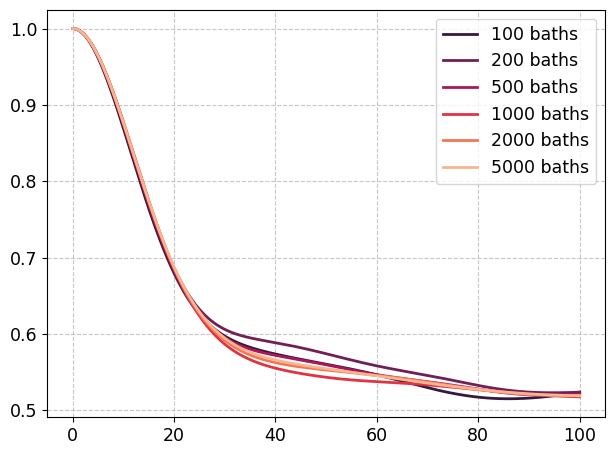

In [208]:
# converge the number of bath configurations 
num_spins = 7

fig, ax = plt.subplots()
colors = sns.color_palette('rocket', n_colors=6)
t_end, t_steps = 100e-6, 500
t_list = np.linspace(0, t_end, t_steps)

for i, num_baths in enumerate([100, 200, 500, 1000, 2000, 5000]):
    batch_idx_list = random.sample(range(1, 51), num_baths//100)
    
    states_merged = 0
    for batch_idx in batch_idx_list: 
        save_filename = f'{num_spins}_spins_batch_{batch_idx}.npy'
        save_loc = os.path.join(save_directory, save_filename)
        states = np.load(save_loc)
        states_merged += states/len(batch_idx_list)

    pop0 = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states_merged]
    ax.plot(t_list * 1e6, pop0, color=colors[i], label=f"{num_baths} baths")
ax.legend()
plt.show()

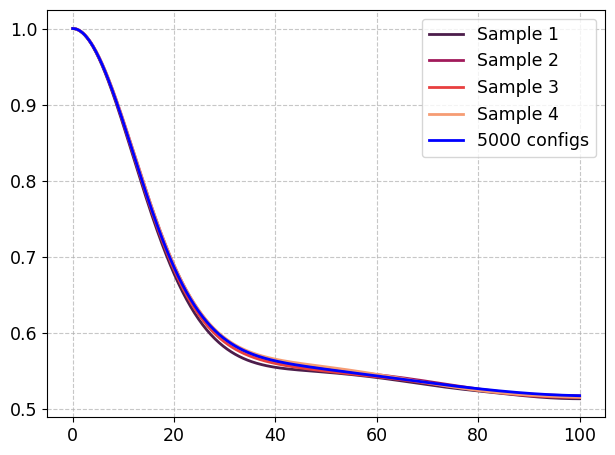

In [209]:
# sampling with the same number of configurations
num_spins = 5
num_configurations = 2000

fig, ax = plt.subplots()
colors = sns.color_palette('rocket', n_colors=4)
t_end, t_steps = 100e-6, 500
t_list = np.linspace(0, t_end, t_steps)

for i in range(4):
    random.seed(i)
    batch_idx_list = random.sample(range(1, 51), num_configurations//100)
    
    states_merged = 0
    for batch_idx in batch_idx_list: 
        save_filename = f'{num_spins}_spins_batch_{batch_idx}.npy'
        save_loc = os.path.join(save_directory, save_filename)
        states = np.load(save_loc)
        states_merged += states/len(batch_idx_list)

    pop0 = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states_merged]
    ax.plot(t_list * 1e6, pop0, color=colors[i], label=f"Sample {i+1}")

save_filename = f'{num_spins}_spins_merged.npy'
save_loc = os.path.join(save_directory, save_filename)
states_merged = np.load(save_loc)

pop0 = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states_merged]
ax.plot(t_list * 1e6, pop0, color='b', label=f"5000 configs")
    
ax.legend()
plt.show()

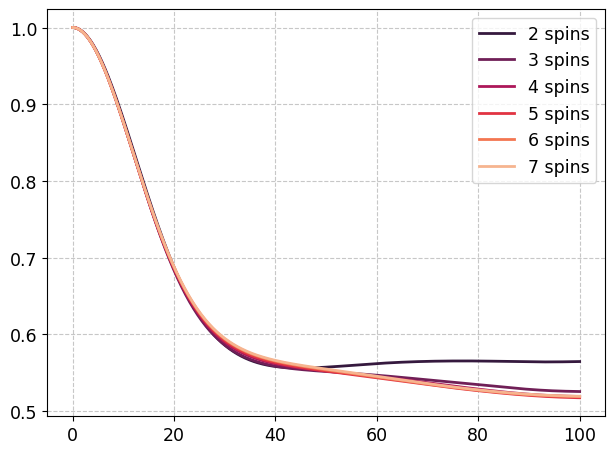

In [210]:
# converge the cutoff radius
colors = sns.color_palette('rocket', n_colors=6)

fig, ax = plt.subplots()
t_end, t_steps = 100e-6, 500
t_list = np.linspace(0, t_end, t_steps)

for i, num_spins in enumerate([2, 3, 4, 5, 6, 7]):
    save_filename = f'{num_spins}_spins_merged.npy'
    save_loc = os.path.join(save_directory, save_filename)
    states_merged = np.load(save_loc)
    
    pop0 = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states_merged]
    ax.plot(t_list * 1e6, pop0, color=colors[i], label=f"{num_spins} spins")
ax.legend()
plt.show()

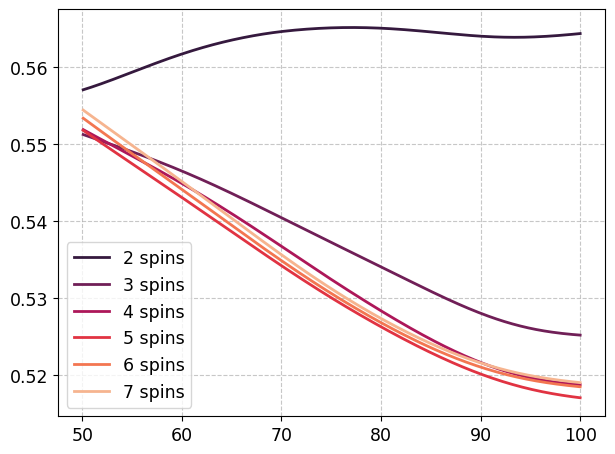

In [211]:
# converge the cutoff radius
colors = sns.color_palette('rocket', n_colors=6)

fig, ax = plt.subplots()
t_end, t_steps = 100e-6, 500
t_list = np.linspace(0, t_end, t_steps)

for i, num_spins in enumerate([2, 3, 4, 5, 6, 7]):
    save_filename = f'{num_spins}_spins_merged.npy'
    save_loc = os.path.join(save_directory, save_filename)
    states_merged = np.load(save_loc)
    
    pop0 = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states_merged]
    ax.plot(t_list[250:] * 1e6, pop0[250:], color=colors[i], label=f"{num_spins} spins")
ax.legend()
plt.show()

### 5. Benchmark the converged parameters

In [105]:
save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", "high_density_10nm_depth")

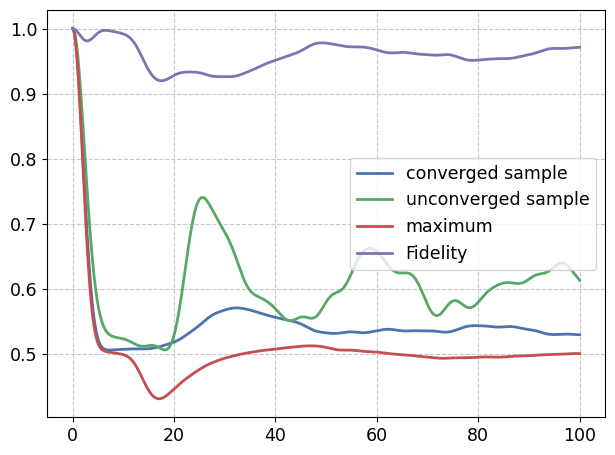

In [106]:
# compare the converged parameters to the maximally calculatable and one unconverged set of parameters
# fidelity cant be defined in the usual way since the states are not pure. difference of population can be considered as trace distance.

colors = sns.color_palette('rocket', n_colors=3)

fig, ax = plt.subplots()
random.seed(123)
t_end, t_steps = 100e-6, 500
t_list = np.linspace(0, t_end, t_steps)

# converge
num_spins = 5
num_configurations = 2000
batch_idx_list = random.sample(range(1, 51), num_configurations//100)

states_merged1 = 0
for batch_idx in batch_idx_list: 
    save_filename = f'{num_spins}_spins_batch_{batch_idx}.npy'
    save_loc = os.path.join(save_directory, save_filename)
    states = np.load(save_loc)
    states_merged1 += states/len(batch_idx_list)

pop0_conv = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states_merged1]
ax.plot(t_list * 1e6, pop0_conv, label='converged sample')

# unconverged
num_spins = 3
num_configurations = 100
batch_idx_list = random.sample(range(1, 51), num_configurations//100)

states_merged2 = 0
for batch_idx in batch_idx_list: 
    save_filename = f'{num_spins}_spins_batch_{batch_idx}.npy'
    save_loc = os.path.join(save_directory, save_filename)
    states = np.load(save_loc)
    states_merged2 += states/len(batch_idx_list)

pop0_unconv = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states_merged2]
ax.plot(t_list * 1e6, pop0_unconv, label='unconverged sample')

# maximum
num_spins = 7 
save_filename = f'{num_spins}_spins_merged.npy'
save_loc = os.path.join(save_directory, save_filename)
states_merged3 = np.load(save_loc)

pop0_max = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states_merged3]
ax.plot(t_list * 1e6, pop0_max, label=f"maximum")

# fidelity
ax.plot(t_list * 1e6, 1-np.abs(np.array(pop0_max) - np.array(pop0_conv)), label='Fidelity' )

ax.legend()
plt.show()

### 6. Benchmark the converged parameters in a magnetic field 

In [95]:
t0 = time.time()

for density_key in ['low_density', 'intermediate_density', 'high_density']:
    for depth in [5e-9, 10e-9, 15e-9]:

        for env_approx_level in ['no_bath', 'full_bath']:
            Bz = 100e-9
            num_configs, num_spins = 2000, 5
            
            directory = os.path.join(os.getcwd(), "baths", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
            
            filename = f'{num_spins}_spins'
            bath_configs = load_spin_baths(filename, directory)
            
            # create an instance of the Environment2 class
            register_config = [('NV', (0, 0, 0), 0, dict(D_gs=0, Bz=Bz, N_zz=0, can_flip=False))]
            bath_configs_batch = bath_configs[:num_configs]
            kwargs = dict(dm_offset=1e-5, verbose=False, env_approx_level=env_approx_level, bath_configs=bath_configs_batch, suter_method=False, thermal_bath=True, parallelization=True)
            env = Environment2(register_config, **kwargs)
            
            # calculate the populations
            t_end, t_steps = 100e-6, 500
            env.gate_props_list = [("free_evo", dict(t=t_end))]
            t_list = np.linspace(0, t_end, t_steps)
            HGate = 1j * env.calc_U_rot(np.pi, 0, theta=np.pi / 4)
            HGate_phase = 1j * env.calc_U_rot(np.pi, np.pi/2, theta=np.pi / 4) # np.pi/2
            old_register_states = [HGate * q.fock_dm(2,0) * HGate]
            states = env.calc_states(t_list=t_list, old_register_states=old_register_states)[0]
            states = np.array([(HGate_phase * state * HGate_phase).full() for state in states])
            
            # saving
            save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
            save_filename = f'.converged_{env_approx_level}_{round(Bz*1e9)}nT_{num_spins}_spins_{num_configs}_conf.npy'
            os.makedirs(save_directory, exist_ok=True)
            save_loc = os.path.join(save_directory, save_filename)
            np.save(save_loc, states)
            print(f'Saved as {save_loc}.npy')
            print("Time: ", time.time()-t0)

Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  0.22169065475463867


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [10:33<00:00,  3.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  638.2228016853333
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  638.2966983318329


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:58<00:00,  3.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  1239.3400058746338
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  1239.4024031162262


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [10:28<00:00,  3.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  1870.8071994781494
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  1870.8894221782684


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:52<00:00,  3.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  2465.3616030216217
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  2465.443169116974


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [10:30<00:00,  3.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  3098.31986784935
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  3098.387687444687


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:59<00:00,  3.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  3640.170097589493
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  3640.2373657226562


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:46<00:00,  3.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  4169.254194736481
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  4169.338775634766


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:49<00:00,  3.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  4700.898597955704
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  4700.9691371917725


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:13<00:00,  3.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  5256.6784081459045


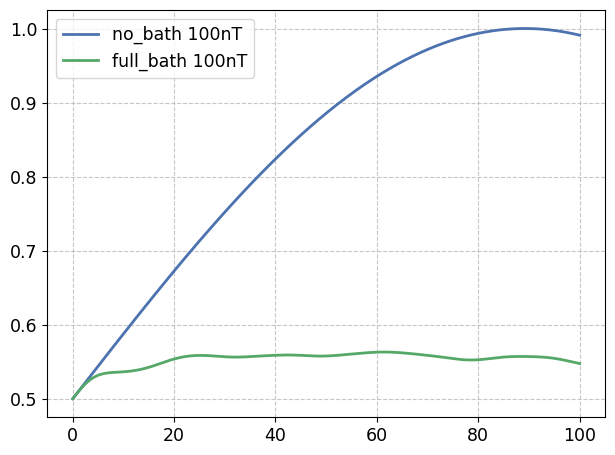

In [111]:
fig, ax = plt.subplots()

density_key = 'intermediate_density'
depth = 10
num_spins = 5

for env_approx_level in ['no_bath', 'full_bath']:
    save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", f"{density_key}_{depth}nm_depth")
    save_filename = f'.converged_{env_approx_level}_{round(Bz*1e9)}nT_{num_spins}_spins_{num_configs}_conf.npy'
    save_loc = os.path.join(save_directory, save_filename)
    states = np.load(save_loc)
    
    pop0 = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states]
    ax.plot(t_list * 1e6, pop0, label=f"{env_approx_level} 100nT")

ax.legend()
plt.show()

## Cluster Expansion

In [183]:
density_key = 'high_density'
depth = 10e-9
num_spins = 7

directory = os.path.join(os.getcwd(), "baths", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
filename = f'{num_spins}_spins'
bath_configs, metadata = load_spin_baths(filename, directory, load_metadata=True)

bath_configs_gCCE = []
num_init_states = 200
num_baths = 100

for i in range(num_init_states):
    for bath_config in bath_configs[:num_baths]:
        spin_types, spin_pos, init_states, kwargs_list = list(zip(*bath_config))
        np.random.seed(i) 
        init_states = np.random.choice([0, 1], size=num_spins).tolist()
        config = list(zip(spin_types, spin_pos, init_states, kwargs_list)) 
        bath_configs_gCCE.append(config)

metadata['num_init_states'] = num_init_states
metadata['num_baths'] = num_baths

save_filename = f'{num_spins}_spins_gCCE'
save_spin_baths(bath_configs_gCCE, metadata, directory, save_filename)

In [185]:
t0 = time.time()

Bz = 0
density_key = 'high_density'
depth = 10e-9
num_spins = 7

directory = os.path.join(os.getcwd(), "baths", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
filename = f'{num_spins}_spins_gCCE'
bath_configs = load_spin_baths(filename, directory)

for env_approx_level in ['gCCE0', 'gCCE1', 'gCCE2']:
    for batch_idx in np.arange(101, 201):
            
            # create an instance of the Environment2 class
            register_config = [('NV', (0, 0, 0), 0, dict(D_gs=0, Bz=Bz, N_zz=0, can_flip=False))]
            bath_configs_batch = bath_configs[(batch_idx-1)*100:batch_idx*100]
            kwargs = dict(dm_offset=1e-5, verbose=False, env_approx_level=env_approx_level, bath_configs=bath_configs_batch, suter_method=False, thermal_bath=True, parallelization=True)
            env = Environment2(register_config, **kwargs)
        
            # calculate the populations
            t_end, t_steps = 100e-6, 500
            env.gate_props_list = [("free_evo", dict(t=t_end))]
            t_list = np.linspace(0, t_end, t_steps)
            HGate = 1j * env.calc_U_rot(np.pi, 0, theta=np.pi / 4)
            HGate_phase = 1j * env.calc_U_rot(np.pi, 0, theta=np.pi / 4) # np.pi/2
            old_register_states = [HGate * q.fock_dm(2,0) * HGate]
            states = env.calc_states(t_list=t_list, old_register_states=old_register_states)[0]
            states = np.array([(HGate_phase * state * HGate_phase).full() for state in states])
            
            # saving
            save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth_gCCE")
            save_filename = f'{num_spins}_spins_{env_approx_level}_batch_{batch_idx}'
            os.makedirs(save_directory, exist_ok=True)
            save_loc = os.path.join(save_directory, save_filename)
            np.save(save_loc, states)
            print(f'Saved as {save_loc}.npy')
            print("Time: ", time.time()-t0)

# time to calculate one batch (100 confs) with 100 init_states
# 474 gCCE0 
# 815 gCCE1
# 1898 gCCE2 * 2000

Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_101.npy
Time:  4.5301148891448975


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_102.npy
Time:  8.839440107345581


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_103.npy
Time:  13.139718055725098


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_104.npy
Time:  17.35939049720764


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_105.npy
Time:  21.780713081359863


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_106.npy
Time:  26.216627597808838


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_107.npy
Time:  30.558480978012085


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.74it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_108.npy
Time:  34.97413492202759


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_109.npy
Time:  39.43706822395325


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_110.npy
Time:  44.01126480102539


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_111.npy
Time:  49.01306438446045


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_112.npy
Time:  54.068846702575684


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_113.npy
Time:  59.17146182060242


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_114.npy
Time:  64.16172504425049


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_115.npy
Time:  69.16171360015869


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_116.npy
Time:  74.20811200141907


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_117.npy
Time:  79.17769956588745


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_118.npy
Time:  84.21092891693115


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_119.npy
Time:  89.2782678604126


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_120.npy
Time:  94.43101978302002


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_121.npy
Time:  99.41350412368774


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_122.npy
Time:  104.51072144508362


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_123.npy
Time:  109.64425945281982


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_124.npy
Time:  114.6681878566742


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_125.npy
Time:  119.7590663433075


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_126.npy
Time:  124.91531348228455


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_127.npy
Time:  129.9337830543518


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_128.npy
Time:  134.99651527404785


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_129.npy
Time:  140.09722566604614


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_130.npy
Time:  145.21551132202148


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_131.npy
Time:  150.3346643447876


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_132.npy
Time:  155.4062421321869


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_133.npy
Time:  160.55576348304749


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_134.npy
Time:  165.59463000297546


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_135.npy
Time:  170.73690271377563


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_136.npy
Time:  175.8195276260376


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_137.npy
Time:  180.89881086349487


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_138.npy
Time:  185.96210432052612


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_139.npy
Time:  191.003173828125


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_140.npy
Time:  196.05825471878052


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_141.npy
Time:  201.03071999549866


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_142.npy
Time:  206.1125738620758


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_143.npy
Time:  211.1292531490326


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_144.npy
Time:  216.10278701782227


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_145.npy
Time:  221.1458933353424


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_146.npy
Time:  226.2104949951172


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_147.npy
Time:  231.3119375705719


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_148.npy
Time:  236.30870294570923


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_149.npy
Time:  241.49244236946106


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_150.npy
Time:  246.73095726966858


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_151.npy
Time:  251.69248342514038


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_152.npy
Time:  256.72239422798157


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_153.npy
Time:  261.7936327457428


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_154.npy
Time:  266.7474479675293


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_155.npy
Time:  271.81783628463745


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_156.npy
Time:  276.87890696525574


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_157.npy
Time:  281.852468252182


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_158.npy
Time:  286.93239307403564


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_159.npy
Time:  291.9909236431122


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_160.npy
Time:  296.95250630378723


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_161.npy
Time:  302.05513191223145


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_162.npy
Time:  307.13033962249756


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_163.npy
Time:  312.2127079963684


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_164.npy
Time:  317.2959179878235


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_165.npy
Time:  322.37870383262634


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_166.npy
Time:  327.4841516017914


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_167.npy
Time:  332.46548795700073


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_168.npy
Time:  337.4621319770813


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_169.npy
Time:  342.6356439590454


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_170.npy
Time:  347.6749129295349


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_171.npy
Time:  352.6279892921448


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_172.npy
Time:  357.67809081077576


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_173.npy
Time:  362.72412061691284


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_174.npy
Time:  367.7508497238159


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_175.npy
Time:  372.79320430755615


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_176.npy
Time:  378.0395624637604


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_177.npy
Time:  383.1846618652344


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_178.npy
Time:  388.28079533576965


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_179.npy
Time:  393.4268157482147


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_180.npy
Time:  398.56961464881897


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_181.npy
Time:  403.4086880683899


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_182.npy
Time:  408.25189685821533


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_183.npy
Time:  413.1149859428406


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_184.npy
Time:  417.9980502128601


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_185.npy
Time:  422.8611478805542


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_186.npy
Time:  427.7451958656311


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_187.npy
Time:  432.6404240131378


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_188.npy
Time:  437.44963359832764


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_189.npy
Time:  442.3079915046692


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_190.npy
Time:  447.2455065250397


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_191.npy
Time:  452.13627457618713


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_192.npy
Time:  456.98177123069763


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_193.npy
Time:  461.9251708984375


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_194.npy
Time:  467.07288813591003


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_195.npy
Time:  472.0678105354309


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_196.npy
Time:  477.0742120742798


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_197.npy
Time:  482.34561014175415


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_198.npy
Time:  487.58509707450867


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_199.npy
Time:  492.57209634780884


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_200.npy
Time:  498.4589684009552


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_101.npy
Time:  507.48124504089355


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_102.npy
Time:  516.099205493927


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_103.npy
Time:  524.8021762371063


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_104.npy
Time:  533.3934495449066


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_105.npy
Time:  541.9807150363922


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_106.npy
Time:  550.9969820976257


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_107.npy
Time:  559.394339799881


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_108.npy
Time:  568.0858995914459


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_109.npy
Time:  576.4600298404694


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_110.npy
Time:  585.2197630405426


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_111.npy
Time:  593.4858958721161


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_112.npy
Time:  601.6865792274475


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_113.npy
Time:  609.9876337051392


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_114.npy
Time:  618.3159317970276


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_115.npy
Time:  626.7976689338684


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_116.npy
Time:  635.4412589073181


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_117.npy
Time:  643.7514865398407


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_118.npy
Time:  652.2652506828308


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_119.npy
Time:  661.096638917923


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_120.npy
Time:  669.5639441013336


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_121.npy
Time:  678.0524809360504


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_122.npy
Time:  686.457870721817


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_123.npy
Time:  695.8977742195129


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_124.npy
Time:  704.3631536960602


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_125.npy
Time:  712.6404905319214


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_126.npy
Time:  721.0897545814514


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_127.npy
Time:  729.3315138816833


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_128.npy
Time:  737.6429665088654


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_129.npy
Time:  745.9836077690125


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_130.npy
Time:  754.2008264064789


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_131.npy
Time:  762.5168845653534


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_132.npy
Time:  771.0215816497803


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_133.npy
Time:  779.1973414421082


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_134.npy
Time:  787.5776076316833


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_135.npy
Time:  795.9232981204987


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_136.npy
Time:  804.5785076618195


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_137.npy
Time:  812.869044303894


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_138.npy
Time:  821.1908242702484


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_139.npy
Time:  829.5302491188049


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_140.npy
Time:  837.752767086029


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_141.npy
Time:  845.9888534545898


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_142.npy
Time:  854.4053990840912


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_143.npy
Time:  862.5794906616211


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_144.npy
Time:  870.9134931564331


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_145.npy
Time:  879.2265479564667


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_146.npy
Time:  887.6329817771912


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_147.npy
Time:  896.6490442752838


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_148.npy
Time:  905.6077754497528


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_149.npy
Time:  914.153706073761


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_150.npy
Time:  922.4206590652466


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_151.npy
Time:  930.7248823642731


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_152.npy
Time:  939.1410558223724


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_153.npy
Time:  947.1950867176056


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_154.npy
Time:  955.1492877006531


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_155.npy
Time:  963.3048746585846


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_156.npy
Time:  971.6039669513702


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_157.npy
Time:  980.4169466495514


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_158.npy
Time:  989.1670825481415


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_159.npy
Time:  997.8490858078003


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_160.npy
Time:  1006.654025554657


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_161.npy
Time:  1015.2089154720306


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_162.npy
Time:  1023.6053233146667


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_163.npy
Time:  1031.8398542404175


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_164.npy
Time:  1040.0377793312073


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_165.npy
Time:  1048.0834701061249


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_166.npy
Time:  1056.3142750263214


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_167.npy
Time:  1065.0597898960114


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_168.npy
Time:  1074.3858227729797


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_169.npy
Time:  1082.8882586956024


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_170.npy
Time:  1091.7322404384613


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_171.npy
Time:  1100.616919517517


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_172.npy
Time:  1109.2001478672028


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_173.npy
Time:  1117.5652697086334


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_174.npy
Time:  1126.550141096115


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_175.npy
Time:  1135.0947580337524


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_176.npy
Time:  1143.2129497528076


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_177.npy
Time:  1151.414297580719


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_178.npy
Time:  1159.9828164577484


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_179.npy
Time:  1168.7179381847382


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_180.npy
Time:  1177.1158783435822


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_181.npy
Time:  1185.286640405655


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_182.npy
Time:  1193.579005241394


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_183.npy
Time:  1201.849833726883


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_184.npy
Time:  1210.1190128326416


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_185.npy
Time:  1218.453050851822


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_186.npy
Time:  1226.6888179779053


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_187.npy
Time:  1234.8048090934753


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_188.npy
Time:  1242.8156538009644


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_189.npy
Time:  1250.857988357544


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_190.npy
Time:  1259.1031374931335


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_191.npy
Time:  1267.3675911426544


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_192.npy
Time:  1275.5553841590881


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_193.npy
Time:  1283.8053741455078


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_194.npy
Time:  1292.0733199119568


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_195.npy
Time:  1300.3649461269379


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_196.npy
Time:  1308.631980895996


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_197.npy
Time:  1316.920892238617


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_198.npy
Time:  1325.1526477336884


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_199.npy
Time:  1333.1832637786865


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.74it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE1_batch_200.npy
Time:  1341.3546667099


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_101.npy
Time:  1360.3939521312714


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_102.npy
Time:  1379.4623336791992


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_103.npy
Time:  1398.5192952156067


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_104.npy
Time:  1417.5264642238617


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_105.npy
Time:  1436.512044429779


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_106.npy
Time:  1455.233121395111


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_107.npy
Time:  1474.319254398346


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_108.npy
Time:  1493.436047554016


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_109.npy
Time:  1512.6903848648071


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_110.npy
Time:  1531.8088850975037


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_111.npy
Time:  1550.668452501297


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_112.npy
Time:  1569.382955789566


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_113.npy
Time:  1588.868374824524


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_114.npy
Time:  1608.575579404831


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_115.npy
Time:  1627.6172297000885


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_116.npy
Time:  1646.7285697460175


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_117.npy
Time:  1665.632380247116


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_118.npy
Time:  1685.1370589733124


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_119.npy
Time:  1704.4106333255768


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_120.npy
Time:  1723.4549806118011


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_121.npy
Time:  1742.4917974472046


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_122.npy
Time:  1761.5529730319977


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_123.npy
Time:  1780.3633933067322


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_124.npy
Time:  1799.6123278141022


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_125.npy
Time:  1818.8916890621185


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_126.npy
Time:  1837.8741238117218


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_127.npy
Time:  1857.1951558589935


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_128.npy
Time:  1876.3206751346588


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_129.npy
Time:  1895.0872328281403


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_130.npy
Time:  1914.3775072097778


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_131.npy
Time:  1933.378323316574


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_132.npy
Time:  1952.6036195755005


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_133.npy
Time:  1971.828072309494


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_134.npy
Time:  1990.8459980487823


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_135.npy
Time:  2009.7095551490784


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_136.npy
Time:  2028.6611123085022


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_137.npy
Time:  2047.9081010818481


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_138.npy
Time:  2067.148250102997


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_139.npy
Time:  2086.2763526439667


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_140.npy
Time:  2105.1928555965424


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_141.npy
Time:  2124.1768720149994


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_142.npy
Time:  2143.487473964691


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_143.npy
Time:  2162.515625476837


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_144.npy
Time:  2181.6513323783875


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_145.npy
Time:  2200.841821193695


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_146.npy
Time:  2219.8188576698303


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_147.npy
Time:  2238.9412581920624


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_148.npy
Time:  2258.01042509079


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_149.npy
Time:  2277.6068255901337


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_150.npy
Time:  2296.6897995471954


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_151.npy
Time:  2315.9142887592316


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_152.npy
Time:  2334.9214375019073


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_153.npy
Time:  2354.2508039474487


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_154.npy
Time:  2373.4167969226837


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_155.npy
Time:  2392.5345339775085


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_156.npy
Time:  2411.725487470627


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_157.npy
Time:  2430.9604840278625


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_158.npy
Time:  2450.2429854869843


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_159.npy
Time:  2469.7288343906403


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_160.npy
Time:  2488.927360534668


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_161.npy
Time:  2507.8910989761353


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_162.npy
Time:  2527.29686832428


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_163.npy
Time:  2546.315099954605


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_164.npy
Time:  2565.563847064972


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_165.npy
Time:  2584.640721797943


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_166.npy
Time:  2603.6859674453735


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_167.npy
Time:  2622.723354101181


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_168.npy
Time:  2641.8624789714813


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_169.npy
Time:  2660.959117412567


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_170.npy
Time:  2679.9054658412933


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_171.npy
Time:  2698.957283973694


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_172.npy
Time:  2718.4186835289


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_173.npy
Time:  2737.825299024582


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_174.npy
Time:  2756.8747029304504


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_175.npy
Time:  2775.8498849868774


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_176.npy
Time:  2795.129387140274


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_177.npy
Time:  2814.2848393917084


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_178.npy
Time:  2833.32284283638


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_179.npy
Time:  2852.4368448257446


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_180.npy
Time:  2871.564384460449


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_181.npy
Time:  2890.582323074341


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_182.npy
Time:  2909.8012931346893


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_183.npy
Time:  2929.145067214966


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_184.npy
Time:  2948.1142394542694


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_185.npy
Time:  2967.106639623642


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_186.npy
Time:  2986.037302494049


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_187.npy
Time:  3005.0239384174347


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_188.npy
Time:  3023.9226245880127


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_189.npy
Time:  3042.859366416931


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_190.npy
Time:  3061.794912815094


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_191.npy
Time:  3080.718897342682


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_192.npy
Time:  3099.9060978889465


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_193.npy
Time:  3119.209134578705


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_194.npy
Time:  3138.5725843906403


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_195.npy
Time:  3158.0631370544434


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_196.npy
Time:  3177.4127492904663


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_197.npy
Time:  3197.514340162277


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_198.npy
Time:  3217.592924118042


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_199.npy
Time:  3237.0008478164673


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.20it/s]

Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE2_batch_200.npy
Time:  3256.520403146744


In [186]:
save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth_gCCE")

for env_approx_level in ['gCCE0', 'gCCE1', 'gCCE2']:
    states_merged = 0
    for batch_idx in np.arange(1, 201):
        save_filename = f'{num_spins}_spins_{env_approx_level}_batch_{batch_idx}.npy'
        save_loc = os.path.join(save_directory, save_filename)
        states = np.load(save_loc)
        states_merged += states/200
    save_filename = f'{num_spins}_spins_{env_approx_level}_merged'
    save_loc = os.path.join(save_directory, save_filename)
    np.save(save_loc, states_merged)

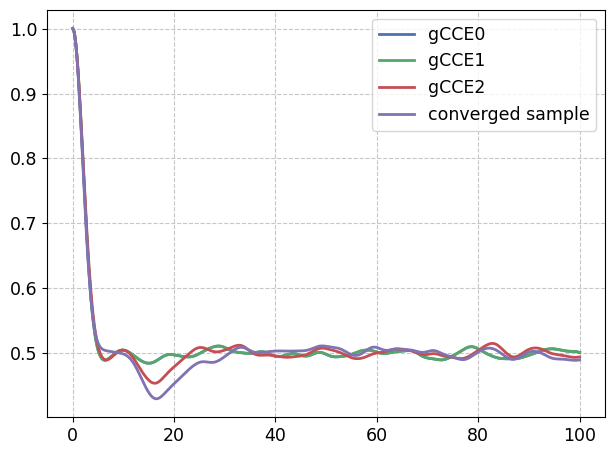

In [187]:
fig, ax = plt.subplots()

density_key = 'high_density'
depth = 10e-9
num_spins = 7

for env_approx_level in ['gCCE0', 'gCCE1', 'gCCE2']:
    save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth_gCCE")
    save_filename = f'{num_spins}_spins_{env_approx_level}_merged.npy'
    save_loc = os.path.join(save_directory, save_filename)
    states = np.load(save_loc)
    
    pop0 = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states]
    ax.plot(t_list * 1e6, pop0, label=f"{env_approx_level}")


batch_idx = 1
save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
save_filename = f'{num_spins}_spins_batch_{batch_idx}.npy'
save_loc = os.path.join(save_directory, save_filename)
states = np.load(save_loc)

pop0_conv = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states]
ax.plot(t_list * 1e6, pop0_conv, label='converged sample')

ax.legend()
plt.show()